![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+GenAI&dt=Vertex+AI+GenAI+Embeddings+-+As+Features+For+Hierarchical+Classification.ipynb)

# Vertex AI GenAI Embeddings - As Features For Hierarchical Classification

**Motivation For This Workflow**

When a new product is added to inventory at a retailer it gets added to a product catalog. Correct placement in a catalog can impact which customer find or a presented with the product - ultimately impacting sales.  Building a model that can turn product descriptions (and images) into correct assignments is a product catalog can help automate product placement.

**Extensions of This Workflow**

The approach here covers an example with a product catalog.  Similar challenges exist in spaces like medical ontologies, content management, and organizational design.  The approach used here could be extended to any example where items are classified into a hierarchy (even a single level).  By framing the challenge as a binary classification and turning text and images into features with embeddings it becomes possible to tackle these normally very tricky analyses.  If the current hierarchy is not correct then it is probably best to first tackle the challenge of cleaning up the existing cateogorizations before training a model to learn the structure.  Embeddings could also be helpful for this with techniques like clusters with k-means.

**Approaches**

A product catalog is typically 2 or more levels, a hierarchy.  A classification model for this hierarchical structure can be approached a number of ways, including:
- Leaf Node classification: build a multi-class classifier for placement into the terminal nodes of the product hierarchy.  This simplifies the problem while also loosing the information provided by the hierarchy.
- Multi-Model classification: build a multi-class classfier in any of the approaches listed here.  This is simple and retains the information in the hierarchy but has issues with managing miss-placement (errors).
    - parent node in the hierarchy
    - level of the hierarchy
    - each node (binary classifier)
- Whole space classification: a number of ways to approach this with the whole hierarchy.  The one considered in this notebook has been referred to as a Kesler's construction as presented in this [blog from Shopify](https://shopify.engineering/categorizing-products-at-scale). This approach is a balance of:
    - simplicity: reduce the whole hierarchy to a binary classifier
    - complete: uses the whole hierarchy as information
    - extendable: while the blog referenced does word tokenizaiton on a unique vocabulary, the approach used in this workflow uses a newer take by creating embeddings of product descriptions and nodes in the product catalog.

Classification models can take several forms:
- Binary classification - classify into one of two categories
- Multi-class classification - classify into one of three or more categories
- Multi-label classification - assign one or more labels to each instance

The approach used here is a combination of multi-class and binary classification.  It will form the model as a binary classification and the inference stage will use the model for multi-class classification.

**Features? Use Embeddings!**

Embeddings are vector representations of text or images or both.  These are vectors of floating point numbers that come from a model that has been trained to embed content in a way that efficiently represents the content.

Getting embeddings for text, or multimodel text and images using Vetex AI foundational models is demonstrated in notebook [Vertex AI GenAI Embeddings](./Vertex%20AI%20GenAI%20Embeddings.ipynb).

This notebook show a use case for embeddings as features. The product hierarchy from a product catalog is represented as features by:
- embedding product descriptions
- embedding node name from the product catalog

**Highlights of This Workflow**
- Working with data in BigQuery using the BigFrames API.  Local syntax with remote (in BigQuery) execution while using a Pandas (and Scikit-Learn) like syntax.
- Serverless model training with BigQuery ML to run XGBoost
- Model Serving with SQL using BigQuery ML and BigQuery SQL.  This is especially helpful as this workflow uses a multi-pass inference approach which is orchestrated efficiently with a single SQL statement.

**Workflow:**
- Review product catalog data in BigQuery Public table: `bigquery-public-data.thelook_ecommerce.products`
- Setup BigQuery Resource Connection
    - Use ML.* to generate embeddings using Vertex AI
- Create a table with embeddings for:
    - `name` = A brief description of the product
    - `department` = The first level of the product catalog
    - `category` = The second level of the product catalog
- Prepare Data for ML
    - Create product hierarchy
    - Create test and train subsets
    - Explode test and train data by cross join with product hierarchy
        - this shapes the data for binary classification
    - Label the data: after the expansion label correct placements versus incorrect placements
- Create Models
    - Build a classifier using concatenated embeddings: product descriptions and node names
    - Build a classifier using absolute difference between embeddings: product descriptions and node names
        - magnitude of difference represents unique or similar qualities
    - Build a classifier using both concatenated embeddings and the absolute difference between embeddings
    - Build a classifier with product metadata AND both concatenated embeddings and the absolute difference between embeddings
- Model Inference
    - How to do inference using a single instance as example
    - Test and Train inference and metrics for each of the models created

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Vertex%20AI%20GenAI%20Embeddings%20-%20As%20Features%20For%20Hierarchical%20Classification.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment.  Also, the API for Artifact Registry needs to be enabled (if not already enabled).

### Installs (If Needed)
The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [611]:
# tuples of (import name, install name)
packages = [
    ('bigframes', 'bigframes'),
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.bigquery_connection_v1', 'google-cloud-bigquery-connection')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### API Enablement

Make sure the [BigQuery Connection API](https://cloud.google.com/bigquery/docs/create-cloud-resource-connection) is enabled:

In [613]:
!gcloud services enable bigqueryconnection.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [612]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
SERIES = 'applied-genai'
EXPERIMENT = 'embed-feature-classifier'

In [3]:
# make this the BQ Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2] # subset to first two characters for multi-region

In [4]:
import json
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import vertexai.language_models
import bigframes.pandas as bf
import bigframes.ml as bfml
from bigframes.ml import llm
from bigframes.ml import model_selection
from bigframes.ml import ensemble
from google.cloud import bigquery_connection_v1 as bq_connection
from google.cloud import bigquery

2023-09-23 15:14:05.148140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarni

In [5]:
vertexai.init(project = PROJECT_ID, location = REGION)
bq = bigquery.Client(project = PROJECT_ID)
bf.reset_session()
bf.options.bigquery.project = BQ_PROJECT
bf.options.bigquery.location = BQ_REGION
bf_session = bf.get_global_session()

---
## Review Data Source

BigQuery Public table `bigquery-public-data.thelook_ecommerce.products`.

### Connect To Source Table: BigQuery Public Table

This is a table of products from a catelog that are arranged into `department` and further grouped into `category`.

In [583]:
products = bf.read_gbq('bigquery-public-data.thelook_ecommerce.products')

HTML(value='Query job cc5cb164-267a-4dd4-9930-d3561474d9af is RUNNING. <a target="_blank" href="https://consol…

In [584]:
products.dtypes

id                                  Int64
cost                              Float64
category                  string[pyarrow]
name                      string[pyarrow]
brand                     string[pyarrow]
retail_price                      Float64
department                string[pyarrow]
sku                       string[pyarrow]
distribution_center_id              Int64
dtype: object

### Review `department`

In [585]:
products['department'].unique().tolist()

HTML(value='Query job 06e9b897-fbaf-4ca2-bafb-fa4edf8b982d is DONE. 410.5 kB processed. <a target="_blank" hre…

['Men', 'Women']

### Review `category`

In [538]:
products['category'].unique().tolist()

HTML(value='Query job 2d49f987-aa3f-437e-88ee-fc771045436c is DONE. 594.2 kB processed. <a target="_blank" hre…

['Swim',
 'Jeans',
 'Pants',
 'Socks',
 'Active',
 'Shorts',
 'Sweaters',
 'Underwear',
 'Accessories',
 'Tops & Tees',
 'Sleep & Lounge',
 'Outerwear & Coats',
 'Suits & Sport Coats',
 'Fashion Hoodies & Sweatshirts',
 'Plus',
 'Suits',
 'Skirts',
 'Dresses',
 'Leggings',
 'Intimates',
 'Maternity',
 'Clothing Sets',
 'Pants & Capris',
 'Socks & Hosiery',
 'Blazers & Jackets',
 'Jumpsuits & Rompers']

In [539]:
products[['department', 'category']].groupby(['department', 'category']).count()

HTML(value='Query job a358697b-3643-4fe9-b8f7-10b794ddf919 is DONE. 538.8 kB processed. <a target="_blank" hre…

HTML(value='Query job 71f19558-54bc-46e3-bd31-6eafbf4cd701 is DONE. 538.8 kB processed. <a target="_blank" hre…

HTML(value='Query job 5d045d13-f3e9-4eeb-bab1-fecb4c392519 is DONE. 0 Bytes processed. <a target="_blank" href…

Empty DataFrame
Columns: []
Index: [(Men, Accessories), (Men, Active), (Men, Fashion Hoodies & Sweatshirts), (Men, Jeans), (Men, Outerwear & Coats), (Men, Pants), (Men, Shorts), (Men, Sleep & Lounge), (Men, Socks), (Men, Suits & Sport Coats), (Men, Sweaters), (Men, Swim), (Men, Tops & Tees), (Men, Underwear), (Women, Accessories), (Women, Active), (Women, Blazers & Jackets), (Women, Clothing Sets), (Women, Dresses), (Women, Fashion Hoodies & Sweatshirts), (Women, Intimates), (Women, Jeans), (Women, Jumpsuits & Rompers), (Women, Leggings), (Women, Maternity)]
...

[36 rows x 0 columns]

**NOTES**

There are categories that duplicate within each department: Jeans, Accessories, ...

It is probably best to accumulate the node descriptions for the hierarchy by concatenating the values for department and category to represent categories.  

In [540]:
products['category'] = products['department'] + ': ' + products['category']

In [541]:
products['category'].unique().tolist()

HTML(value='Query job 2d344f55-0b88-4b20-8587-91e1d20a49f8 is DONE. 771.7 kB processed. <a target="_blank" hre…

['Men: Swim',
 'Men: Jeans',
 'Men: Pants',
 'Men: Socks',
 'Men: Active',
 'Men: Shorts',
 'Men: Sweaters',
 'Men: Underwear',
 'Men: Accessories',
 'Men: Tops & Tees',
 'Men: Sleep & Lounge',
 'Men: Outerwear & Coats',
 'Men: Suits & Sport Coats',
 'Men: Fashion Hoodies & Sweatshirts',
 'Women: Plus',
 'Women: Swim',
 'Women: Jeans',
 'Women: Suits',
 'Women: Active',
 'Women: Shorts',
 'Women: Skirts',
 'Women: Dresses',
 'Women: Leggings',
 'Women: Sweaters',
 'Women: Intimates',
 'Women: Maternity',
 'Women: Accessories',
 'Women: Tops & Tees',
 'Women: Clothing Sets',
 'Women: Pants & Capris',
 'Women: Sleep & Lounge',
 'Women: Socks & Hosiery',
 'Women: Blazers & Jackets',
 'Women: Outerwear & Coats',
 'Women: Jumpsuits & Rompers',
 'Women: Fashion Hoodies & Sweatshirts']

Review the row counts for each `category` within `department` to check for balance (or imbalance). Imbalance will lead to the nead for stratified sampling when creating splits for train and test.

In [542]:
products['category'].value_counts().to_pandas()

HTML(value='Query job 1840a104-d69b-40be-a7e8-5f3109ec3103 is DONE. 538.8 kB processed. <a target="_blank" hre…

category
Women: Intimates                        2363
Men: Jeans                              1117
Men: Underwear                          1088
Men: Tops & Tees                        1084
Men: Pants                              1041
Men: Sweaters                            999
Men: Fashion Hoodies & Sweatshirts       971
Women: Dresses                           955
Men: Sleep & Lounge                      941
Men: Shorts                              939
Men: Swim                                906
Men: Socks                               905
Women: Maternity                         898
Women: Fashion Hoodies & Sweatshirts     895
Women: Swim                              892
Women: Jeans                             882
Women: Sleep & Lounge                    830
Men: Outerwear & Coats                   828
Women: Shorts                            826
Men: Accessories                         820
Women: Tops & Tees                       784
Women: Plus                              758
M

### Review `name`: The product description

In [543]:
products['name'].head(10)

HTML(value='Query job d9c4305e-85f7-445b-a68c-80fb2a2e7a44 is DONE. 233.0 kB processed. <a target="_blank" hre…

HTML(value='Query job ccf71226-b948-479b-85af-dbee8caab285 is DONE. 1.7 MB processed. <a target="_blank" href=…

0       2XU Men's Swimmers Compression Long Sleeve Top
1           TYR Sport Men's Square Leg Short Swim Suit
2      TYR Sport Men's Solid Durafast Jammer Swim Suit
3    TYR Sport Men's Swim Short/Resistance Short Sw...
4                      TYR Alliance Team Splice Jammer
5     TYR Sport Men's 4-Inch Nylon Trainer-A Swim Suit
6               TYR Sport Men's Solid Jammer Swim Suit
7          TYR Sport Men's Poly Mesh Trainer Swim Suit
8    TYR Sport Men's Alliance Durafast Splice Squar...
9                TYR Sport Men's Solid Racer Swim Suit
Name: name, dtype: string

---
## Create BigQuery Dataset

In [544]:
# create/link to dataset
ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
ds.location = BQ_REGION
ds.labels = {'series': f'{SERIES}'}
ds = bq.create_dataset(dataset = ds, exists_ok = True) 

---
## BigQuery ML: Connect To Vertex AI LLMs with ML.GENERATE_TEXT

BigQuery ML can `Create Model`s that are actually connections to Remote Models. [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-remote-model)

Using the `REMOTE_SERVICE_TYPE = "CLOUD_AI_LARGE_LANGUAGE_MODEL_V1"` option will link to LLMs in Vertex AI!

### Connection Requirement

To make a remote connection using BigQuery ML, BigQuery uses a CLOUD_RESOURCE connection. [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-remote-model#connection)

Create a new connection with type `CLOUD_RESOURCE`: First, check for existing connection.

In [16]:
try:
    response = bq_connection.ConnectionServiceClient().get_connection(
            request = bq_connection.GetConnectionRequest(
                name = f"projects/{BQ_PROJECT}/locations/{BQ_REGION}/connections/{SERIES}_{EXPERIMENT}"
            )
    )
    print(f'Found existing connection with service account: {response.cloud_resource.service_account_id}')
    service_account = response.cloud_resource.service_account_id
except Exception:
    request = bq_connection.CreateConnectionRequest(
        {
            "parent": f"projects/{BQ_PROJECT}/locations/{BQ_REGION}",
            "connection_id": f"{SERIES}_{EXPERIMENT}",
            "connection": bq_connection.types.Connection(
                {
                    "friendly_name": f"{SERIES}_{EXPERIMENT}",
                    "cloud_resource": bq_connection.CloudResourceProperties({})
                }
            )
        }
    )
    response = bq_connection.ConnectionServiceClient().create_connection(request)
    print(f'Created new connection with service account: {response.cloud_resource.service_account_id}')
    service_account = response.cloud_resource.service_account_id
    # assign the service account the Vertex AI User Role:
    !gcloud projects add-iam-policy-binding {BQ_PROJECT} --member=serviceAccount:{service_account} --role=roles/aiplatform.user

Found existing connection with service account: bqcx-1026793852137-pdxa@gcp-sa-bigquery-condel.iam.gserviceaccount.com


**NOTE**: The step above created a service account and assigned it the Vertex AI User Role.  This may take a moment to be recognized in the steps below.  If you get an error in one of the cells below try rerunning it.

### Create The Remote Model In BigQuery

Create a temp model that connects to text embedding model on Vertex AI - [Reference](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.ml.llm.PaLM2TextEmbeddingGenerator)

In [17]:
embed_model = bfml.llm.PaLM2TextEmbeddingGenerator(
    session = bf_session,
    connection_name = f'{BQ_PROJECT}.{BQ_REGION}.{SERIES}_{EXPERIMENT}'
)

HTML(value='Query job 69b9018d-33a9-44c6-9c33-092d99762362 is RUNNING. <a target="_blank" href="https://consol…

---
## Create Embeddings

### For Product Descriptions: Name

**NOTE**: The following cell will create embedding requests for all 29k+ values in the `name` column and could take around **10 minutes** to run.

In [18]:
products = products.join(embed_model.predict(products['name']).rename(columns={'text_embedding':'name_embedding'}))

HTML(value='Query job 5198d374-1a18-4ba2-a9b3-fb884752b3fd is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 8710953e-d880-4fed-b50c-f12b8e27d9bf is DONE. 233.0 kB processed. <a target="_blank" hre…

In [19]:
products.head()

HTML(value='Query job 987c64d1-e59a-49cf-9c88-45c62ce354e2 is DONE. 465.9 kB processed. <a target="_blank" hre…

HTML(value='Query job 4ba3effa-b875-4720-b2fa-7c3ea5017302 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 53da9618-5b5e-4e9f-9e55-17fb557a13fa is DONE. 0 Bytes processed. <a target="_blank" href…

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id,name_embedding
0,27569,92.652563,Men: Swim,2XU Men's Swimmers Compression Long Sleeve Top,2XU,150.410004,Men,B23C5765E165D83AA924FA8F13C05F25,1,"[0.021811574697494507, -0.0068705384619534016,..."
1,27445,24.719661,Men: Swim,TYR Sport Men's Square Leg Short Swim Suit,TYR,38.990002,Men,2AB7D3B23574C3DEA2BD278AFD0939AB,1,"[0.04419781640172005, -0.009351101703941822, 0..."
2,27457,15.8976,Men: Swim,TYR Sport Men's Solid Durafast Jammer Swim Suit,TYR,27.6,Men,8F831227B0EB6C6D09A0555531365933,1,"[0.0471641980111599, -0.03273119032382965, 0.0..."
3,27466,17.85,Men: Swim,TYR Sport Men's Swim Short/Resistance Short Sw...,TYR,30.0,Men,67317D6DCC4CB778AEB9219565F5456B,1,"[0.049136240035295486, 0.0037870346568524837, ..."
4,27481,29.408001,Men: Swim,TYR Alliance Team Splice Jammer,TYR,45.950001,Men,213C888198806EF1A0E2BBF2F4855C6C,1,"[0.0008693744894117117, -0.00447087874636054, ..."


### For Level 1 of Product Hierarchy: Department

This step will run quickly as it only creates embedding request for unique values of `department`.

In [20]:
department = products['department'].unique().to_frame()
department = department.join(embed_model.predict(department).rename(columns={'text_embedding':'department_embedding'}))

HTML(value='Query job 29419c8d-d599-4ee8-9648-23b61b4b3c5f is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job ebeeefaa-539c-4f4a-8c61-2c5655da6c11 is DONE. 16 Bytes processed. <a target="_blank" hre…

In [21]:
department.head()

HTML(value='Query job 10a245d0-8b81-4d64-a072-f13e0f068147 is DONE. 643.5 kB processed. <a target="_blank" hre…

HTML(value='Query job df51b3dd-dc91-45b7-bf89-878024287425 is DONE. 655.8 kB processed. <a target="_blank" hre…

HTML(value='Query job 58424e6d-a888-497f-a405-fec4cc8ad686 is DONE. 0 Bytes processed. <a target="_blank" href…

,department,department_embedding
0,Men,"[-0.04335380345582962, 0.00046764410217292607,..."
13131,Women,"[-0.03191345930099487, -0.006457726005464792, ..."


In [22]:
products = products.merge(department, on = 'department')
products.dtypes

id                                  Int64
cost                              Float64
category                  string[pyarrow]
name                      string[pyarrow]
brand                     string[pyarrow]
retail_price                      Float64
department                string[pyarrow]
sku                       string[pyarrow]
distribution_center_id              Int64
name_embedding                     object
department_embedding               object
dtype: object

### For Level 2 of Product Hierarchy: Category

This step will run quickly as it only creates embedding request for unique values of `category`.

In [23]:
category = products['category'].unique().to_frame()
category = category.join(embed_model.predict(category).rename(columns={'text_embedding':'category_embedding'}))

HTML(value='Query job 63b3f590-164e-4d25-bbb1-fd11b8469949 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 2de1e807-a067-4339-9db1-a83cc3bee9ac is DONE. 288 Bytes processed. <a target="_blank" hr…

In [24]:
category.head()

HTML(value='Query job a588b4c3-2dbe-4a4e-ba7b-a3653c9a7f0b is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job aaabd852-4cea-45bc-a216-245c10de7296 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 5ccfd30f-81bc-4910-a8a7-a86ac0d6e541 is DONE. 0 Bytes processed. <a target="_blank" href…

,category,category_embedding
0,Men: Swim,"[0.024325380101799965, 0.0083873076364398, 0.0..."
906,Men: Jeans,"[-0.033402811735868454, 0.007221992593258619, ..."
2023,Men: Pants,"[-0.019241666421294212, 0.023088112473487854, ..."
3064,Men: Socks,"[0.03812064602971077, 0.02077236771583557, 0.0..."
3969,Men: Active,"[0.026801789179444313, 5.999019049340859e-05, ..."


In [25]:
products = products.merge(category, on = 'category')
products.dtypes

id                                  Int64
cost                              Float64
category                  string[pyarrow]
name                      string[pyarrow]
brand                     string[pyarrow]
retail_price                      Float64
department                string[pyarrow]
sku                       string[pyarrow]
distribution_center_id              Int64
name_embedding                     object
department_embedding               object
category_embedding                 object
dtype: object

### Make BigQuery Tables of Results

The `products`, `department`, and `category` dataframes are currently temporary tables in BigQuery.  To recall these for future use it is best to store them as actual BigQuery tables using the [.to_gbq](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.dataframe.DataFrame#bigframes_dataframe_DataFrame_to_gbq) method as follows.

In [547]:
products.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_products', if_exists = 'replace', index = False)
department.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_department', if_exists = 'replace', index = False)
category.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_category', if_exists = 'replace', index = False)

HTML(value='Query job ff4fd53e-6f1a-41d7-8cfd-e62ad0703b5b is RUNNING. <a target="_blank" href="https://consol…

On subsequent runs, skip the creation of the tables above and run the following cell to link the already created tables:

In [6]:
#products = bf.read_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_products')
#department = bf.read_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_department')
#category = bf.read_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_category')

HTML(value='Query job 00b911bd-9639-4d81-9359-2ec1be4544a4 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 9f00dc6a-5746-4ea5-96c0-326f8a8fb808 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 1b66ccbb-4249-4c8c-b41b-be5e9b74b2ce is RUNNING. <a target="_blank" href="https://consol…

---
## Prepare Data For ML

### Create product hierarchy set (level 1): department

In [7]:
department.dtypes

department              string[pyarrow]
department_embedding             object
dtype: object

In [8]:
department_hierarchy = department[['department', 'department_embedding']].rename(columns = {"department":"hierarchy_node", "department_embedding":"hierarchy_node_embedding"})
department_hierarchy['hierarchy_level'] = 'department'
department_hierarchy['hierarchy_node_parent'] = 'ALL'
department_hierarchy.dtypes

hierarchy_node              string[pyarrow]
hierarchy_node_embedding             object
hierarchy_level             string[pyarrow]
hierarchy_node_parent       string[pyarrow]
dtype: object

In [9]:
department_hierarchy.head()

HTML(value='Query job 9bc0e9ac-8258-4ec4-9be7-39aa189ec242 is DONE. 16 Bytes processed. <a target="_blank" hre…

HTML(value='Query job 263b62a3-7448-435a-86c3-c0a2ec92e3ae is DONE. 12.3 kB processed. <a target="_blank" href…

HTML(value='Query job 55c0bb6a-1057-4ab8-9e94-e96e6ad22a8e is DONE. 0 Bytes processed. <a target="_blank" href…

,hierarchy_node,hierarchy_node_embedding,hierarchy_level,hierarchy_node_parent
0,Women,"[-0.03191345930099487, -0.006457726005464792, ...",department,ALL
1,Men,"[-0.04335380345582962, 0.00046764410217292607,...",department,ALL


### Create product hierarchy set (level 2): category

In [10]:
category.dtypes

category              string[pyarrow]
category_embedding             object
dtype: object

In [11]:
category_hierarchy = category[['category', 'category_embedding']].rename(
    columns = {
        "category":"hierarchy_node", 
        "category_embedding":"hierarchy_node_embedding"
    }
)
category_hierarchy['hierarchy_level'] = 'category'
category_hierarchy.dtypes

hierarchy_node              string[pyarrow]
hierarchy_node_embedding             object
hierarchy_level             string[pyarrow]
dtype: object

In [12]:
category_hierarchy.shape

HTML(value='Query job 0fa4fef9-65df-4f05-aa8f-a19bad1b1604 is DONE. 0 Bytes processed. <a target="_blank" href…

(36, 3)

In [13]:
category_hierarchy = category_hierarchy.merge(
    products[['department', 'category']].drop_duplicates(),
    how = 'left',
    left_on = 'hierarchy_node',
    right_on = 'category').rename(
        columns = {
            "department":"hierarchy_node_parent"
        }
    ).drop(['category'], axis = 1)

In [14]:
category_hierarchy.shape

HTML(value='Query job dfc03878-f60f-4023-9944-cc604cf466f9 is DONE. 950.0 kB processed. <a target="_blank" hre…

(36, 4)

In [15]:
category_hierarchy

HTML(value='Query job fc1bff9b-396e-4343-860c-acc9559bc3c4 is DONE. 1.2 MB processed. <a target="_blank" href=…

HTML(value='Query job 5cb4f0a0-394e-4c9c-9684-159e8d060ca2 is DONE. 0 Bytes processed. <a target="_blank" href…

,hierarchy_node,hierarchy_node_embedding,hierarchy_level,hierarchy_node_parent
0,Men: Outerwear & Coats,"[0.04458973929286003, 0.0012087016366422176, 0...",category,Men
1,Men: Pants,"[-0.019241666421294212, 0.023088112473487854, ...",category,Men
2,Women: Fashion Hoodies & Sweatshirts,"[0.02415217086672783, -0.020421436056494713, 0...",category,Women
3,Men: Accessories,"[0.008520721457898617, 0.008341425098478794, 0...",category,Men
4,Women: Sweaters,"[0.004959301557391882, -0.0004995136405341327,...",category,Women
5,Women: Shorts,"[0.015928752720355988, 0.02097945660352707, 0....",category,Women
6,Men: Socks,"[0.03812064602971077, 0.02077236771583557, 0.0...",category,Men
7,Women: Intimates,"[0.021416962146759033, -0.008486137725412846, ...",category,Women
8,Women: Tops & Tees,"[0.02482634410262108, 0.0009079090086743236, 0...",category,Women
9,Women: Dresses,"[-0.0023509482853114605, -0.017660530284047127...",category,Women


### Create product hierarchy: combine department (level 1) and category (level 2)

In [16]:
product_hierarchy = bf.concat([department_hierarchy, category_hierarchy])

In [17]:
product_hierarchy.head()

HTML(value='Query job 48cb874b-641c-47e3-8fcf-cb881ee43ba6 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 40467f07-055a-4451-946c-5968f81b6752 is DONE. 1.2 MB processed. <a target="_blank" href=…

HTML(value='Query job 26feaaf2-82ff-4e21-888c-7fd92e231293 is DONE. 0 Bytes processed. <a target="_blank" href…

,hierarchy_node,hierarchy_node_embedding,hierarchy_level,hierarchy_node_parent
0,Women,"[-0.03191345930099487, -0.006457726005464792, ...",department,ALL
1,Men,"[-0.04335380345582962, 0.00046764410217292607,...",department,ALL
0,Men: Outerwear & Coats,"[0.04458973929286003, 0.0012087016366422176, 0...",category,Men
1,Men: Pants,"[-0.019241666421294212, 0.023088112473487854, ...",category,Men
2,Women: Fashion Hoodies & Sweatshirts,"[0.02415217086672783, -0.020421436056494713, 0...",category,Women


### Create test and train subsets of products

Create lists of index values for rows allocated to training and test splits.

**Stratified Sampling**

There are an imbalanced number of products across the department and category levels.  It is best to create test/train splits that resemble the distribution of this imbalance.  

In [18]:
# make dataframe from just category (included departement)
full_index = products['category'].to_frame()
# move the index to a column named index
full_index = full_index.reset_index()
# get list of strata levels
strata = full_index['category'].unique().tolist()
# move the dataframe to local pandas
full_index = full_index.to_numpy()

HTML(value='Query job 12dc0dd2-33f2-4dbc-bd4e-9e2ecff065b2 is DONE. 771.7 kB processed. <a target="_blank" hre…

HTML(value='Query job e3268755-81a9-433f-8e82-91efcae27db1 is RUNNING. <a target="_blank" href="https://consol…

In [19]:
strata

['Women: Accessories',
 'Women: Pants & Capris',
 'Women: Socks & Hosiery',
 'Women: Jumpsuits & Rompers',
 'Men: Underwear',
 'Women: Fashion Hoodies & Sweatshirts',
 'Men: Pants',
 'Men: Shorts',
 'Women: Suits',
 'Women: Dresses',
 'Women: Skirts',
 'Women: Intimates',
 'Men: Accessories',
 'Women: Jeans',
 'Men: Active',
 'Men: Fashion Hoodies & Sweatshirts',
 'Men: Socks',
 'Men: Jeans',
 'Men: Outerwear & Coats',
 'Women: Swim',
 'Men: Tops & Tees',
 'Women: Outerwear & Coats',
 'Women: Sweaters',
 'Men: Sweaters',
 'Women: Active',
 'Men: Sleep & Lounge',
 'Women: Sleep & Lounge',
 'Men: Suits & Sport Coats',
 'Women: Blazers & Jackets',
 'Women: Tops & Tees',
 'Women: Leggings',
 'Women: Plus',
 'Men: Swim',
 'Women: Maternity',
 'Women: Clothing Sets',
 'Women: Shorts']

In [20]:
# loop through strata and accumlate the test(10%)/train(90%) splits with row index lists
for i, s in enumerate(strata):
    # retrieve index value for strata s
    level = full_index[full_index[:, 1] == s][:,0]
    # randomly sort the index values
    np.random.shuffle(level)
    # split the index values into 10 chunks
    split = np.array_split(level, 10)
    # allocate the last 9 chunk to train (90%)
    train = np.concatenate(split[1:])
    # allocate the last chunk to test (10%)
    test = split[0]
    # accumulate the test and train index value across all strata levels
    if i == 0:
        train_index = train
        test_index = test
    else:
        train_index = np.concatenate((train_index, train))
        test_index = np.concatenate((test_index, test))

Apply the test/train index lists and create test/train dataframes:

In [21]:
train_products = products[['id', 'name', 'name_embedding', 'category', 'department', 'cost', 'brand', 'retail_price']].iloc[train_index.tolist()]
test_products = products[['id', 'name', 'name_embedding', 'category', 'department', 'cost', 'brand', 'retail_price']].iloc[test_index.tolist()]

HTML(value='Load job b09a5f26-84eb-4063-9b27-7fa77537c463 is RUNNING. <a target="_blank" href="https://console…

HTML(value='Load job 1b5b6e35-3c76-4924-b4e0-35a918ad92d4 is RUNNING. <a target="_blank" href="https://console…

Review the distribution of the Train and Test splits:

In [22]:
pd.concat(
    [
        train_products['category'].value_counts().to_pandas().reset_index().rename(columns = {"count":"Train Count"}),
        test_products['category'].value_counts().to_pandas().reset_index().rename(columns = {"count":"Test Count"})['Test Count'],
        train_products['category'].value_counts(normalize = True).to_pandas().reset_index().rename(columns = {"count":"Train Percentage"})['Train Percentage'].mul(100).round(2).astype(str) + '%',
        test_products['category'].value_counts(normalize = True).to_pandas().reset_index().rename(columns = {"count":"Test Percentage"})['Test Percentage'].mul(100).round(2).astype(str) + '%'
    ],
    axis = 1
)

HTML(value='Query job de11ff3a-a486-407b-b677-b1b09d96aaa7 is DONE. 981.3 kB processed. <a target="_blank" hre…

HTML(value='Query job 94e9ce61-a1cd-4cf3-b225-83f0d9ebcfd2 is DONE. 795.2 kB processed. <a target="_blank" hre…

HTML(value='Query job f90e1be7-9ab0-4754-bfbe-411b520fa18c is DONE. 981.3 kB processed. <a target="_blank" hre…

HTML(value='Query job f4f2faf4-a12b-4910-9f92-da3ca87c5bb2 is DONE. 795.2 kB processed. <a target="_blank" hre…

,category,Train Count,Test Count,Train Percentage,Test Percentage
0,Women: Intimates,2126,237,8.12%,8.09%
1,Men: Jeans,1005,112,3.84%,3.83%
2,Men: Underwear,979,109,3.74%,3.72%
3,Men: Tops & Tees,975,109,3.72%,3.72%
4,Men: Pants,936,105,3.57%,3.59%
5,Men: Sweaters,899,100,3.43%,3.42%
6,Men: Fashion Hoodies & Sweatshirts,873,98,3.33%,3.35%
7,Women: Dresses,859,96,3.28%,3.28%
8,Men: Sleep & Lounge,846,95,3.23%,3.24%
9,Men: Shorts,845,94,3.23%,3.21%


### Create Training And Test Data: Explode product data by crossing with product hierarchy

In [23]:
# cross not yet implemented in bigframes 0.3.0 so see workaround that follows using dummy columns
#train_products = train_products.merge(product_hierarchy, how = 'cross')

**NOTE**: The cross join does not seem to be available yet on the BigFrames API ([Reference](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.pandas#bigframes_pandas_merge)).  To work around this adding a dummy column to both tables to do an inner join on.

In [24]:
train_products['dummy'] = 1
test_products['dummy'] = 1
product_hierarchy['dummy'] = 1

In [25]:
train_products = train_products.merge(product_hierarchy, how = 'inner', on = 'dummy').drop('dummy', axis = 1)
test_products = test_products.merge(product_hierarchy, how = 'inner', on = 'dummy').drop('dummy', axis = 1)
product_hiearchy = product_hierarchy.drop('dummy', axis = 1)

### Add Label To Training Training And Test Data

In [26]:
train_products_yes = train_products[((train_products['category'] == train_products['hierarchy_node']) & (train_products['hierarchy_level'] == 'category')) | ((train_products['department'] == train_products['hierarchy_node']) & (train_products['hierarchy_level'] == 'department'))]
train_products_yes['label'] = 1
train_products_no = train_products[((train_products['category'] != train_products['hierarchy_node']) & (train_products['hierarchy_level'] == 'category')) | ((train_products['department'] != train_products['hierarchy_node']) & (train_products['hierarchy_level'] == 'department'))]
train_products_no['label'] = 0

train_products = bf.concat([train_products_yes, train_products_no])

In [27]:
test_products_yes = test_products[((test_products['category'] == test_products['hierarchy_node']) & (test_products['hierarchy_level'] == 'category')) | ((test_products['department'] == test_products['hierarchy_node']) & (test_products['hierarchy_level'] == 'department'))]
test_products_yes['label'] = 1
test_products_no = test_products[((test_products['category'] != test_products['hierarchy_node']) & (test_products['hierarchy_level'] == 'category')) | ((test_products['department'] != test_products['hierarchy_node']) & (test_products['hierarchy_level'] == 'department'))]
test_products_no['label'] = 0

test_products = bf.concat([test_products_yes, test_products_no])

Make BigQuery tables from the temporary tables:

In [28]:
train_products.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_train_products', if_exists = 'replace', index = False)
test_products.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_products', if_exists = 'replace', index = False)

HTML(value='Query job f85f69bb-c01e-40cd-bc82-8be3b46dba90 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 364adeed-84fa-4a43-940a-b87d41924de7 is RUNNING. <a target="_blank" href="https://consol…

---
## Create Models

Build a classifier model from:
- the combination of embedding vectors from the product name (`name`) and the node name from the product hierarchy
- the absolute difference between the two embedding vectors repesenting the product and the node in the product hierarchy
- metadata variables about products like brand, cost and price

Using BigQuery ML with the BigFrame API via bigframes.ml.ensemble.XGBClassifier!

**Notes on BigQuery ML Usage Here**

BigQuery ML gives serverless access to machine learning directly within BigQuery.  From SQL (Create Model...) and now from a scikit-learn like API with BigFrames (bigframes.ml...).  BigQuery will use either TensorFlow or XGBoost based on the model type selected and translate the paramters to the native model specification within those frameworks.  There are also many functions available for evaulating and using models. A great overview can be found [here](https://cloud.google.com/bigquery/docs/e2e-journey) and this repository has many examples that can be reviewed [here](../03%20-%20BigQuery%20ML%20(BQML)/readme.md).  

There are limitations that are being balanced in the examples that follow.  When the choice of parameters like `max_depth`, `max_iterations` and `num_parallel_trees` gets too large the training stops and error messages indicate the need to make the model specifications less complex.  Another approach is to keep the complexity and use a configurable training resource like Vertex AI Training Jobs or even the local notebook environment with configurable compute like Vertex AI Workbench Instances.

### Prepare Train and Test For Model Input

In [29]:
features = ''
for i in range(768):
    features += f""",
    name_embedding[{i}] as name_{i}, hierarchy_node_embedding[{i}] as hier_{i}, ABS(name_embedding[{i}] - hierarchy_node_embedding[{i}]) as adiff_{i} """

test_input_query = f"""
SELECT * {features}
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_products`
WHERE name is not null AND hierarchy_node is not null
"""

train_input_query = f"""
SELECT * {features}
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_train_products`
WHERE name is not null
    AND ARRAY_LENGTH(name_embedding) > 0
    AND ARRAY_LENGTH(hierarchy_node_embedding) > 0
"""

In [30]:
#print(test_input)

In [31]:
test_input = bf.read_gbq(test_input_query)

HTML(value='Query job 25c88b63-da8f-4ec9-a205-f4a1d77f2566 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job a2dbb7cd-7d2f-49fd-8fb9-422d6e25a788 is RUNNING. <a target="_blank" href="https://consol…

In [32]:
test_input.shape

HTML(value='Query job 5089abc0-f719-4e49-9560-5a67b04c243f is DONE. 0 Bytes processed. <a target="_blank" href…

(111264, 2317)

In [33]:
train_input = bf.read_gbq(train_input_query)

HTML(value='Query job 5a142835-1a98-4b58-a91a-243fdda79dfe is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 4788e7cf-9d90-471c-8a00-00eaafe7594a is RUNNING. <a target="_blank" href="https://consol…

In [34]:
train_input.shape

HTML(value='Query job 7fc207bf-77c2-453a-ae65-4e561051329c is DONE. 0 Bytes processed. <a target="_blank" href…

(995220, 2317)

In [35]:
train_input.dtypes

id                          Int64
name              string[pyarrow]
name_embedding             object
category          string[pyarrow]
department        string[pyarrow]
                       ...       
hier_766                  Float64
adiff_766                 Float64
name_767                  Float64
hier_767                  Float64
adiff_767                 Float64
Length: 2317, dtype: object

In [36]:
train_input.columns

Index(['id', 'name', 'name_embedding', 'category', 'department', 'cost',
       'brand', 'retail_price', 'hierarchy_node', 'hierarchy_node_embedding',
       ...
       'adiff_764', 'name_765', 'hier_765', 'adiff_765', 'name_766',
       'hier_766', 'adiff_766', 'name_767', 'hier_767', 'adiff_767'],
      dtype='object', length=2317)

### (1) Train Classifier: Concatenate Embeddings as Features

Training time is around: 52 minutes

In [442]:
classifier_model = bfml.ensemble.XGBClassifier(max_depth = 10, max_iterations = 40)

In [443]:
features = [col for col in train_input.columns if (col.startswith('name_') or col.startswith('hier_')) and col != 'name_embedding']

In [ ]:
classifier_model.fit(X = train_input[features], y = train_input['label'])

HTML(value='Query job 17bc45d3-8bf1-4127-8603-8166e49defed is RUNNING. <a target="_blank" href="https://consol…

In [ ]:
classifier_model.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_classifier', replace = True)

In [ ]:
classifier_model.get_params()

In [ ]:
classifier_model.predict(X = test_input.head())

### (2) Train Classifier: Absolute Difference Between Embeddings as Features

Training time is around: 1 hour

In [ ]:
classifier_model_adiff = bfml.ensemble.XGBClassifier(max_depth = 10, max_iterations = 40)

In [ ]:
features = [col for col in train_input.columns if col.startswith('adiff_')]

In [ ]:
classifier_model_adiff.fit(X = train_input[features], y = train_input['label'])

In [ ]:
classifier_model_adiff.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_classifier_adiff', replace = True)

In [ ]:
classifier_model_adiff.get_params()

In [ ]:
classifier_model_adiff.predict(X = test_input.head())

### (3) Train Classifier: Concatenated Embedding AND Absolute Difference Between Embeddings as Features

Training time is around: 1 hour 55 minutes

This approach combines all the features of the two approach above - essentiall all three embedding vectors.  Additionally, the hyperparameters for maximum tree depth (6 to 15) and maximum number of iterations (20 to 50) are also increase.

In [ ]:
classifier_model_conadiff = bfml.ensemble.XGBClassifier(max_depth = 15, max_iterations = 50)

In [ ]:
features = [col for col in train_input.columns if (col.startswith('adiff_') or col.startswith('name_') or col.startswith('hier_')) and col != 'name_embedding']

In [ ]:
classifier_model_conadiff.fit(X = train_input[features], y = train_input['label'])

In [ ]:
classifier_model_conadiff.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_classifier_conadiff', replace = True)

In [ ]:
classifier_model_conadiff.get_params()

In [ ]:
classifier_model_conadiff.predict(X = test_input.head())

### (4) Train Classifier: Metadata PLUS Concatenated Embedding AND Absolute Difference Between Embeddings as Features

Training time is around: 1 hour 46 minutes

This approach combines all the features of the two/three approach above - essentiall all three embedding vectors AND it adds in product metadata (cost, retail price, and brand).  Additionally, the hyperparameters for maximum tree depth (6 to 12) and maximum number of iterations (20 to 50) are also increase.

In [ ]:
classifier_model_metaconadiff = bfml.ensemble.XGBClassifier(max_depth = 12, max_iterations = 50)

In [ ]:
features = ['cost', 'brand', 'retail_price'] + [col for col in train_input.columns if (col.startswith('adiff_') or col.startswith('name_') or col.startswith('hier_')) and col != 'name_embedding']

In [ ]:
classifier_model_metaconadiff.fit(X = train_input[features], y = train_input['label'])

In [ ]:
classifier_model_metaconadiff.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_classifier_metaconadiff', replace = True)

In [ ]:
classifier_model_metaconadiff.get_params()

In [ ]:
classifier_model_metaconadiff.predict(X = test_input.head())

### (5) Train Classifier: Metadata PLUS Absolute Difference Between Embeddings as Features

Training time is around: 9 hours 39 minutes

Trying to overcome the overfitting observed in prior models by making a boosted forested: a forest (10 trees) that each have max_depth = 12 and max_iterations = 40. 

In [37]:
classifier_model_forest_metaconadiff = bfml.ensemble.XGBClassifier(num_parallel_tree = 10, colsample_bytree = 1, subsample = 0.80, max_depth = 12, max_iterations = 40)

In [38]:
features = ['cost', 'brand', 'retail_price'] + [col for col in train_input.columns if col.startswith('adiff_')]

In [39]:
classifier_model_forest_metaconadiff.fit(X = train_input[features], y = train_input['label'])

HTML(value='Query job d81e1dfd-892e-432c-b961-aa20c45dd5af is RUNNING. <a target="_blank" href="https://consol…

XGBClassifier(colsample_bytree=1, max_depth=12, max_iterations=40,
              num_parallel_tree=10, subsample=0.8)

In [40]:
classifier_model_forest_metaconadiff.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_classifier_forest_metaconadiff', replace = True)

HTML(value='Copy job 6b3ecafa-00c0-4aba-9d19-a0a1b0ce02fc is RUNNING. <a target="_blank" href="https://console…

XGBClassifier(booster='GBTREE', max_depth=12, max_iterations=40,
              num_parallel_tree=10, subsample=0.8, tree_method='AUTO')

In [41]:
classifier_model_forest_metaconadiff.get_params()

{'booster': 'gbtree',
 'colsample_bylevel': 1.0,
 'colsample_bynode': 1.0,
 'colsample_bytree': 1,
 'dart_normalized_type': 'TREE',
 'early_stop': True,
 'enable_global_explain': False,
 'gamma': 0.0,
 'learning_rate': 0.3,
 'max_depth': 12,
 'max_iterations': 40,
 'min_rel_progress': 0.01,
 'min_tree_child_weight': 1,
 'num_parallel_tree': 10,
 'reg_alpha': 0.0,
 'reg_lambda': 1.0,
 'subsample': 0.8,
 'tree_method': 'auto',
 'xgboost_version': '0.9'}

In [42]:
classifier_model_forest_metaconadiff.predict(X = test_input.head())

HTML(value='Query job 34c79640-4924-4353-b89c-0211688297d6 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job e57cb18a-ef58-404f-acfd-54922aae7523 is DONE. 40 Bytes processed. <a target="_blank" hre…

HTML(value='Query job eceac6ea-67da-4bd8-8ebc-28196bfcc30e is DONE. 0 Bytes processed. <a target="_blank" href…

HTML(value='Query job 89ed7c45-a842-42a0-ab26-a46b6feb6b5f is DONE. 80 Bytes processed. <a target="_blank" hre…

HTML(value='Query job a7924c7d-938c-4d83-be43-7069f33e7094 is DONE. 0 Bytes processed. <a target="_blank" href…

,predicted_label
0,0
1,0
2,0
3,0
4,0


---
---
---
# NOTE: Switching To BigQuery API
    
Working with the model in BigQuery ML requires some features that are not yet in the BigFrames API.  The following section switches to the BigQuery API and uses SQL to retrive results to local Pandas dataframes.

**EXAMPLE**

In the section above the `.predict()` method was used to retrive predictions.  The only column returned is the predicted label.  For this project the probability for each class label is needed to infer the right placement in the product hierarchy.

In [600]:
# save model input to BigQuery Tables
train_input.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_train_input', if_exists = 'replace', index = False)
test_input.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input', if_exists = 'replace', index = False)

HTML(value='Query job 6a6b2817-81f4-42e3-9649-a1eb158f54da is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 1201b30b-e5fb-43cf-b0b6-8a16f6fb77a0 is RUNNING. <a target="_blank" href="https://consol…

---
## Model Inference: Develop Approach With 1 Instance

Request predictions.  With this data shape the process is iterative.

In [44]:
LIMITER = 'LIMIT 1' # level blank for all
MODEL_NAME = 'classifier' # specify model name between classifier and classifier_adiff

query = f"""
SELECT *
FROM ML.PREDICT (
    MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_{MODEL_NAME}`,
    (
        SELECT *
        FROM (SELECT id FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input` {LIMITER})
        LEFT OUTER JOIN `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input`
        USING(id)
    )
)
"""

In [45]:
pred = bq.query(query = query).to_dataframe()

In [46]:
pred.shape

(38, 2319)

In [47]:
pred.head()

,predicted_label,predicted_label_probs,id,name,name_embedding,category,department,cost,brand,retail_price,...,adiff_764,name_765,hier_765,adiff_765,name_766,hier_766,adiff_766,name_767,hier_767,adiff_767
0,1,"[{'label': 1, 'prob': 0.9918966889381409}, {'l...",28659,Men's Leather Driving Gloves with Velcro Strap...,"[0.0006357092643156648, -0.0008928530151024461...",Men: Accessories,Men,14.8188,Pratt and Hart,34.950001,...,0.021986,0.006834,0.007084,0.000251,-0.044587,-0.033502,0.011085,-0.002681,-0.034115,0.031434
1,0,"[{'label': 1, 'prob': 0.00851924903690815}, {'...",28659,Men's Leather Driving Gloves with Velcro Strap...,"[0.0006357092643156648, -0.0008928530151024461...",Men: Accessories,Men,14.8188,Pratt and Hart,34.950001,...,0.014870,0.006834,-0.003109,0.009943,-0.044587,0.022030,0.066618,-0.002681,-0.038412,0.035730
2,0,"[{'label': 1, 'prob': 0.004069044254720211}, {...",28659,Men's Leather Driving Gloves with Velcro Strap...,"[0.0006357092643156648, -0.0008928530151024461...",Men: Accessories,Men,14.8188,Pratt and Hart,34.950001,...,0.016522,0.006834,0.006052,0.000781,-0.044587,-0.017790,0.026798,-0.002681,-0.015279,0.012598
3,0,"[{'label': 1, 'prob': 0.00124010827858001}, {'...",28659,Men's Leather Driving Gloves with Velcro Strap...,"[0.0006357092643156648, -0.0008928530151024461...",Men: Accessories,Men,14.8188,Pratt and Hart,34.950001,...,0.013788,0.006834,0.031676,0.024842,-0.044587,-0.006275,0.038312,-0.002681,-0.009226,0.006545
4,0,"[{'label': 1, 'prob': 0.0277833454310894}, {'l...",28659,Men's Leather Driving Gloves with Velcro Strap...,"[0.0006357092643156648, -0.0008928530151024461...",Men: Accessories,Men,14.8188,Pratt and Hart,34.950001,...,0.007425,0.006834,-0.030413,0.037246,-0.044587,-0.000316,0.044272,-0.002681,-0.032499,0.029818


**Note**

Each product has two nodes they are placed in within the hierarchy: department and category withing department.  The predictions are presented for all possible nodes of the hierarchy.  The next step is to reduce the columns returned and expand the predicted_label_probs and present the predicted probability for label = 1.

In [48]:
LIMITER = 'LIMIT 1' # level blank for all
MODEL_NAME = 'classifier' # specify model name between classifier and classifier_adiff

query = f"""
SELECT *
FROM (
    SELECT id, predicted_label_probs, label, name, category, department, hierarchy_level, hierarchy_node, hierarchy_node_parent
    FROM ML.PREDICT (
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_{MODEL_NAME}`,
        (
            WITH limiter AS (SELECT id FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input` {LIMITER})
            SELECT *
            FROM limiter
            LEFT OUTER JOIN `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input`
            USING(id)
        )
    )
) p
CROSS JOIN UNNEST(p.predicted_label_probs) as probs
WHERE probs.label = 1
"""

In [49]:
pred = bq.query(query = query).to_dataframe()

In [50]:
pred.shape

(38, 11)

In [51]:
pred.head()

,id,predicted_label_probs,label,name,category,department,hierarchy_level,hierarchy_node,hierarchy_node_parent,label_1,prob
0,28659,"[{'label': 1, 'prob': 0.00851924903690815}, {'...",0,Men's Leather Driving Gloves with Velcro Strap...,Men: Accessories,Men,category,Men: Suits & Sport Coats,Men,1,0.008519
1,28659,"[{'label': 1, 'prob': 0.9918966889381409}, {'l...",1,Men's Leather Driving Gloves with Velcro Strap...,Men: Accessories,Men,department,Men,ALL,1,0.991897
2,28659,"[{'label': 1, 'prob': 0.004069044254720211}, {...",0,Men's Leather Driving Gloves with Velcro Strap...,Men: Accessories,Men,department,Women,ALL,1,0.004069
3,28659,"[{'label': 1, 'prob': 0.906542956829071}, {'la...",1,Men's Leather Driving Gloves with Velcro Strap...,Men: Accessories,Men,category,Men: Accessories,Men,1,0.906543
4,28659,"[{'label': 1, 'prob': 0.0277833454310894}, {'l...",0,Men's Leather Driving Gloves with Velcro Strap...,Men: Accessories,Men,category,Men: Sleep & Lounge,Men,1,0.027783


**Note**

For the each id value, what is the predicted placement in the hierarchy?

This requires making inference down the structure of the hierarchy:
- what is highest predicted probability for `department`?
- what is highest predicted probability for `category` within the selected `department`?
- Is the answer right or wrong?

In [52]:
LIMITER = 'LIMIT 1' # level blank for all
MODEL_NAME = 'classifier' # specify model name between classifier and classifier_adiff

query = f"""
WITH
probs AS (
    SELECT *
    FROM (
        SELECT id, predicted_label_probs, label, name, category, department, hierarchy_level, hierarchy_node, hierarchy_node_parent
        FROM ML.PREDICT (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_{MODEL_NAME}`,
            (
                WITH limiter AS (SELECT id FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input` {LIMITER})
                SELECT *
                FROM limiter
                LEFT OUTER JOIN `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input`
                USING(id)
            )
        )
    ) p
    CROSS JOIN UNNEST(p.predicted_label_probs) as probs
    WHERE probs.label = 1
),
department AS (
    SELECT id, name, category, department, hierarchy_node as pred_department, prob as pred_department_prob
    FROM probs
    WHERE hierarchy_level = 'department'
    QUALIFY row_number() OVER (PARTITION BY id ORDER by prob DESC) = 1
),
category AS (
    SELECT * EXCEPT(hierarchy_node_parent)
    FROM department
    LEFT OUTER JOIN (
        SELECT id, hierarchy_node as pred_category, hierarchy_node_parent, prob as pred_category_prob
        FROM probs
        WHERE hierarchy_level = 'category'
    ) p
    USING(id)
    WHERE department.pred_department = p.hierarchy_node_parent
    QUALIFY row_number() OVER (PARTITION BY id ORDER by pred_category_prob DESC) = 1
)
SELECT *
FROM category
"""
pred = bq.query(query = query).to_dataframe()
pred.head()

,id,name,category,department,pred_department,pred_department_prob,pred_category,pred_category_prob
0,5495,Allegra K Women Elastic Rise Slant Pockets Cas...,Women: Pants & Capris,Women,Women,0.995503,Women: Pants & Capris,0.547126


---
## Model Inference: All Instances

Request predictions.  With this data shape the process is iterative.

In [53]:
def predictor(MODEL_NAME, DATA_TYPE):
    # MODEL_NAME = 'classifier' specify model name between classifier and classifier_adiff
    # DATA_TYPE = 'test' # specify test or train
    
    query = f"""
    WITH
    probs AS (
        SELECT *
        FROM (
            SELECT id, predicted_label_probs, label, name, category, department, hierarchy_level, hierarchy_node, hierarchy_node_parent
            FROM ML.PREDICT (
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_{MODEL_NAME}`,
                (
                    SELECT *
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_{DATA_TYPE}_input`
                )
            )
        ) p
        CROSS JOIN UNNEST(p.predicted_label_probs) as probs
        WHERE probs.label = 1
    ),
    department AS (
        SELECT id, name, category, department, hierarchy_node as pred_department, prob as pred_department_prob
        FROM probs
        WHERE hierarchy_level = 'department'
        QUALIFY row_number() OVER (PARTITION BY id ORDER by prob DESC) = 1
    ),
    category AS (
        SELECT * EXCEPT(hierarchy_node_parent)
        FROM department
        LEFT OUTER JOIN (
            SELECT id, hierarchy_node as pred_category, hierarchy_node_parent, prob as pred_category_prob
            FROM probs
            WHERE hierarchy_level = 'category'
        ) p
        USING(id)
        WHERE department.pred_department = p.hierarchy_node_parent
        QUALIFY row_number() OVER (PARTITION BY id ORDER by pred_category_prob DESC) = 1
    )
    SELECT *
    FROM category
    """
    return bq.query(query = query).to_dataframe()
    

## (1) Model Serving: Classifier For Concatenated Embeddings

### Test Split

In [478]:
test_pred = predictor('classifier', 'test')

In [479]:
test_pred.head()

,id,name,category,department,pred_department,pred_department_prob,pred_category,pred_category_prob
0,1593,Plus size Gray Deep cut v-neck Hoodie top,Women: Fashion Hoodies & Sweatshirts,Women,Women,0.977398,Women: Fashion Hoodies & Sweatshirts,0.242399
1,1703,Burton Women's Her Logo Zip Hoodie,Women: Fashion Hoodies & Sweatshirts,Women,Women,0.972329,Women: Fashion Hoodies & Sweatshirts,0.346093
2,2234,Escargot Sportswear - Crystal Cardinals Novelt...,Women: Fashion Hoodies & Sweatshirts,Women,Women,0.929155,Women: Fashion Hoodies & Sweatshirts,0.091419
3,2804,Mammut Women's Ultimate Hoody,Women: Active,Women,Women,0.992012,Women: Fashion Hoodies & Sweatshirts,0.350029
4,3130,Parker Women's Beaded Shift Dress,Women: Dresses,Women,Women,0.999395,Women: Dresses,0.988408


In [480]:
test_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,1252,67
Women,76,1533


In [481]:
print(
    metrics.classification_report(
        list(test_pred['department']),
        list(test_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       0.94      0.95      0.95      1319
       Women       0.96      0.95      0.96      1609

    accuracy                           0.95      2928
   macro avg       0.95      0.95      0.95      2928
weighted avg       0.95      0.95      0.95      2928



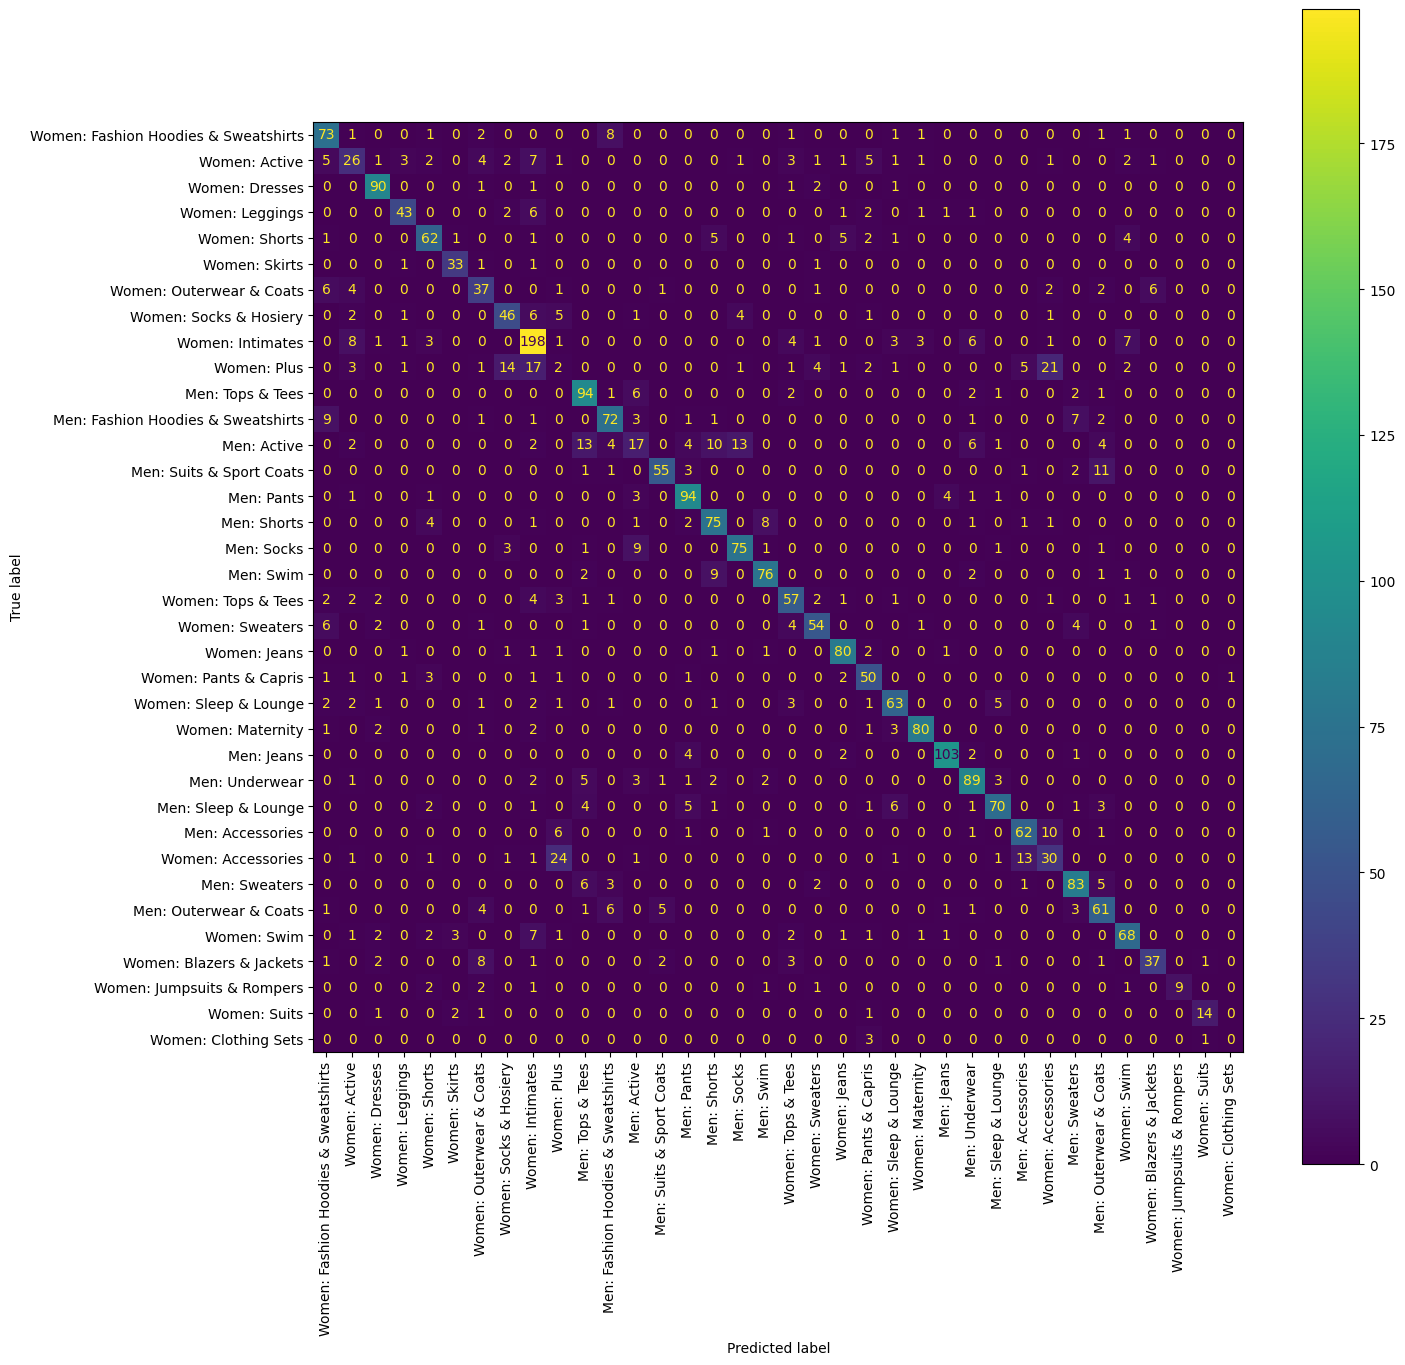

In [482]:
labels = list(test_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(test_pred['category']),
        list(test_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [483]:
print(
    metrics.classification_report(
        list(test_pred['category']),
        list(test_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.75      0.76      0.75        82
                         Men: Active       0.39      0.22      0.28        76
  Men: Fashion Hoodies & Sweatshirts       0.74      0.73      0.74        98
                          Men: Jeans       0.93      0.92      0.92       112
              Men: Outerwear & Coats       0.65      0.73      0.69        83
                          Men: Pants       0.81      0.90      0.85       105
                         Men: Shorts       0.71      0.80      0.75        94
                 Men: Sleep & Lounge       0.83      0.74      0.78        95
                          Men: Socks       0.80      0.82      0.81        91
            Men: Suits & Sport Coats       0.86      0.74      0.80        74
                       Men: Sweaters       0.81      0.83      0.82       100
                           Men: Swim       0.84      0.84      

### Train Split

In [484]:
train_pred = predictor('classifier', 'train')

In [485]:
train_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,11719,92
Women,28,14351


In [486]:
print(
    metrics.classification_report(
        list(train_pred['department']),
        list(train_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       1.00      0.99      0.99     11811
       Women       0.99      1.00      1.00     14379

    accuracy                           1.00     26190
   macro avg       1.00      1.00      1.00     26190
weighted avg       1.00      1.00      1.00     26190



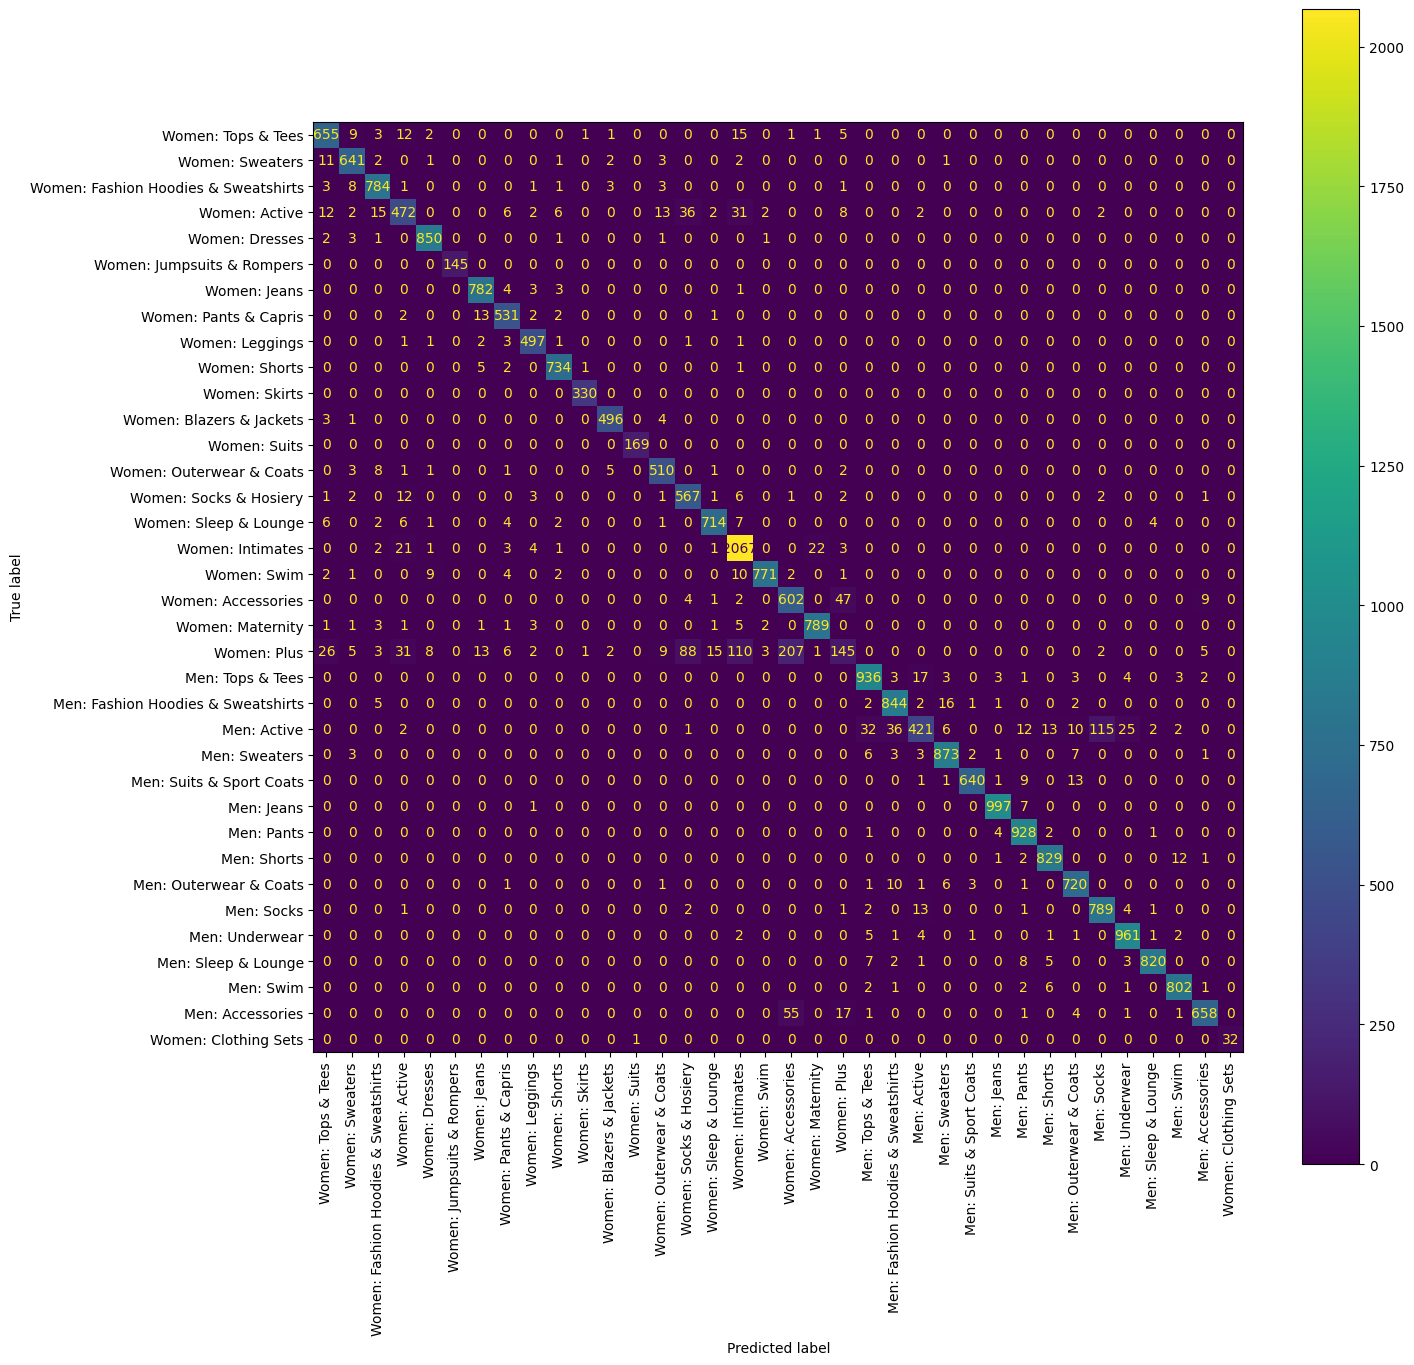

In [487]:
labels = list(train_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(train_pred['category']),
        list(train_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [488]:
print(
    metrics.classification_report(
        list(train_pred['category']),
        list(train_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.97      0.89      0.93       738
                         Men: Active       0.91      0.62      0.74       677
  Men: Fashion Hoodies & Sweatshirts       0.94      0.97      0.95       873
                          Men: Jeans       0.99      0.99      0.99      1005
              Men: Outerwear & Coats       0.95      0.97      0.96       744
                          Men: Pants       0.95      0.99      0.97       936
                         Men: Shorts       0.97      0.98      0.97       845
                 Men: Sleep & Lounge       0.99      0.97      0.98       846
                          Men: Socks       0.87      0.97      0.92       814
            Men: Suits & Sport Coats       0.99      0.96      0.98       665
                       Men: Sweaters       0.96      0.97      0.97       899
                           Men: Swim       0.98      0.98      

### Notes

This approach is very accurate at the top level of the hierarchy, `department`, but weak at `category` placement. It does look like extending the training to additional iterations (stopped at default 20) and making deeper trees (defaulted to 6 here) would be beneficial. 

## (2) Model Serving: Classifier For Absolute Difference Between Embeddings

### Test Split

In [489]:
test_pred = predictor('classifier_adiff', 'test')

In [490]:
test_pred.head()

,id,name,category,department,pred_department,pred_department_prob,pred_category,pred_category_prob
0,610,FUNFASH SLIMMING GOTHIC BLACK TOP SHIRT BLOUSE...,Women: Tops & Tees,Women,Women,0.969571,Women: Tops & Tees,0.639321
1,4156,Love Tease Print Shortall,Women: Jumpsuits & Rompers,Women,Women,0.888046,Women: Skirts,0.324941
2,8895,Snoozies Knit Womens Fleece Lined Footies Hot ...,Women: Socks & Hosiery,Women,Women,0.991902,Women: Plus,0.576321
3,8925,Textured Cable Knit Knee High Socks by Foot Tr...,Women: Socks & Hosiery,Women,Men,0.619356,Men: Socks,0.578763
4,11067,Vanity Fair Women's Tailored Seamless Bikini,Women: Intimates,Women,Women,0.992268,Women: Intimates,0.430685


In [491]:
test_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,1222,97
Women,86,1523


In [492]:
print(
    metrics.classification_report(
        list(test_pred['department']),
        list(test_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       0.93      0.93      0.93      1319
       Women       0.94      0.95      0.94      1609

    accuracy                           0.94      2928
   macro avg       0.94      0.94      0.94      2928
weighted avg       0.94      0.94      0.94      2928



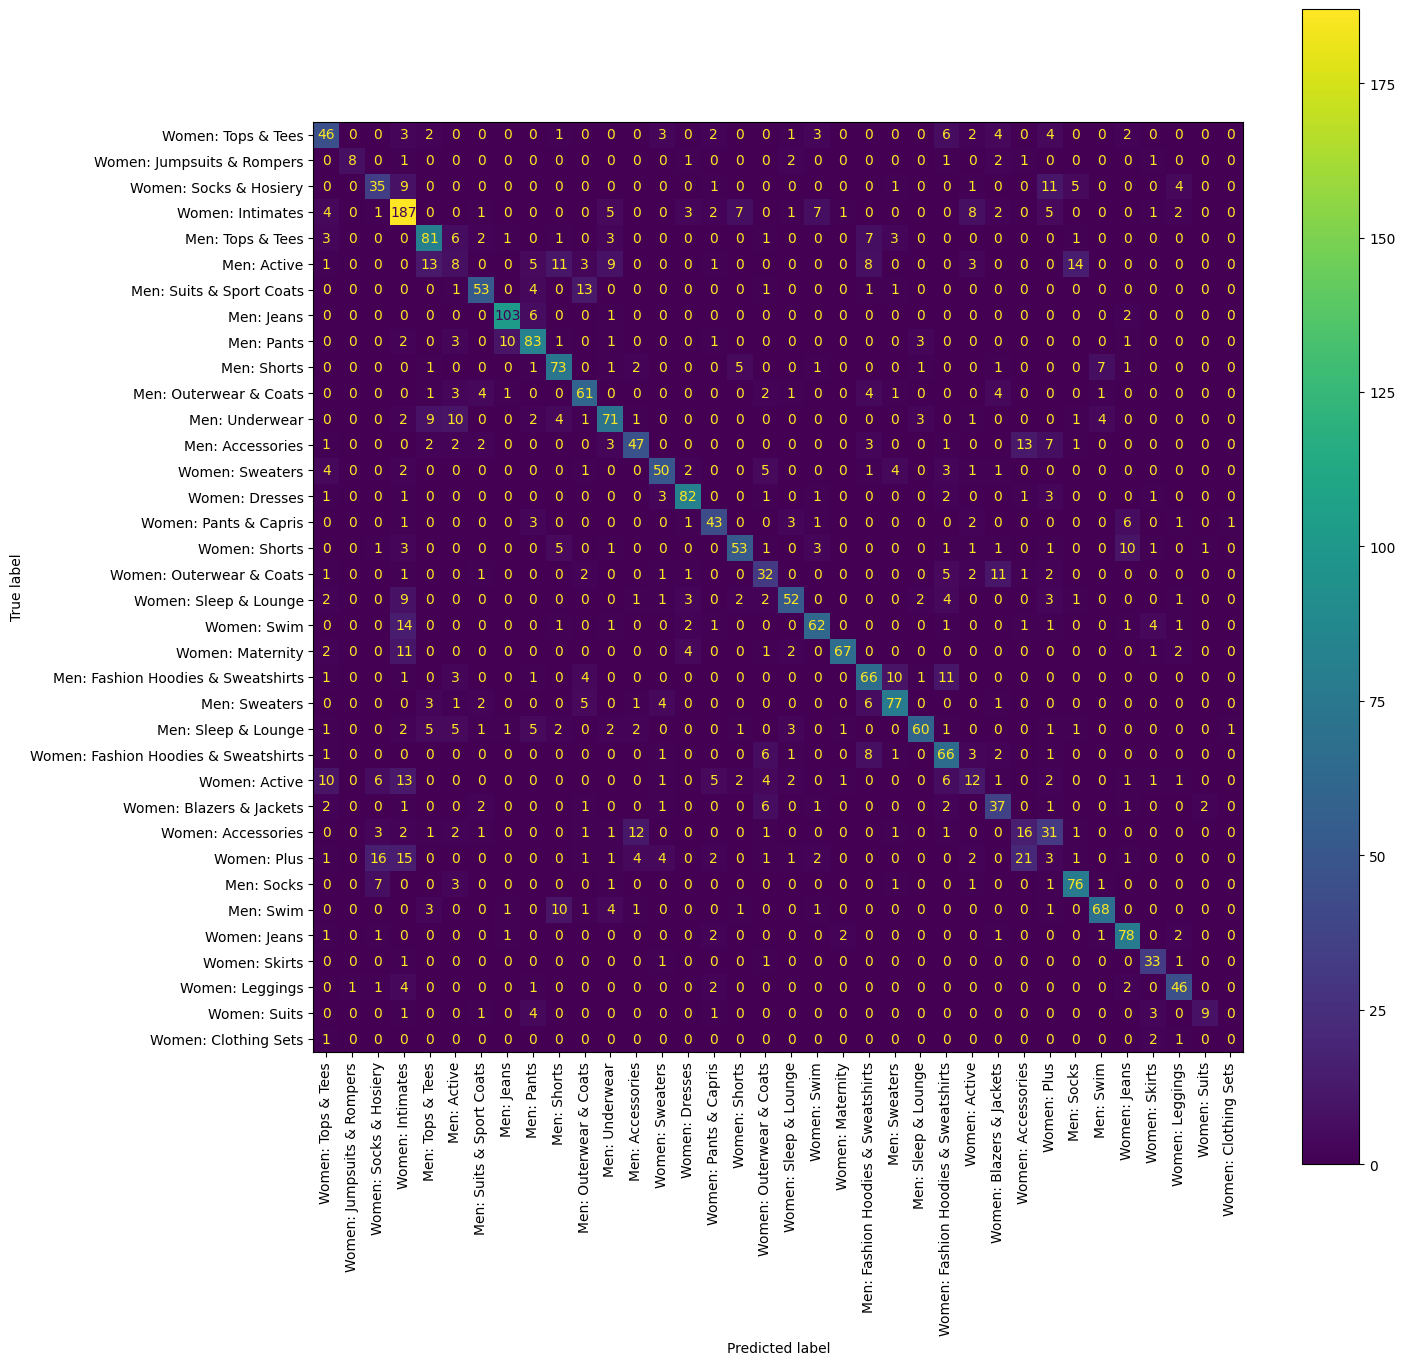

In [493]:
labels = list(test_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(test_pred['category']),
        list(test_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [494]:
print(
    metrics.classification_report(
        list(test_pred['category']),
        list(test_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.66      0.57      0.61        82
                         Men: Active       0.17      0.11      0.13        76
  Men: Fashion Hoodies & Sweatshirts       0.63      0.67      0.65        98
                          Men: Jeans       0.87      0.92      0.90       112
              Men: Outerwear & Coats       0.65      0.73      0.69        83
                          Men: Pants       0.72      0.79      0.75       105
                         Men: Shorts       0.67      0.78      0.72        94
                 Men: Sleep & Lounge       0.86      0.63      0.73        95
                          Men: Socks       0.75      0.84      0.79        91
            Men: Suits & Sport Coats       0.76      0.72      0.74        74
                       Men: Sweaters       0.77      0.77      0.77       100
                           Men: Swim       0.83      0.75      

### Train Split

In [495]:
train_pred = predictor('classifier_adiff', 'train')

In [496]:
train_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,11700,111
Women,46,14333


In [497]:
print(
    metrics.classification_report(
        list(train_pred['department']),
        list(train_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       1.00      0.99      0.99     11811
       Women       0.99      1.00      0.99     14379

    accuracy                           0.99     26190
   macro avg       0.99      0.99      0.99     26190
weighted avg       0.99      0.99      0.99     26190



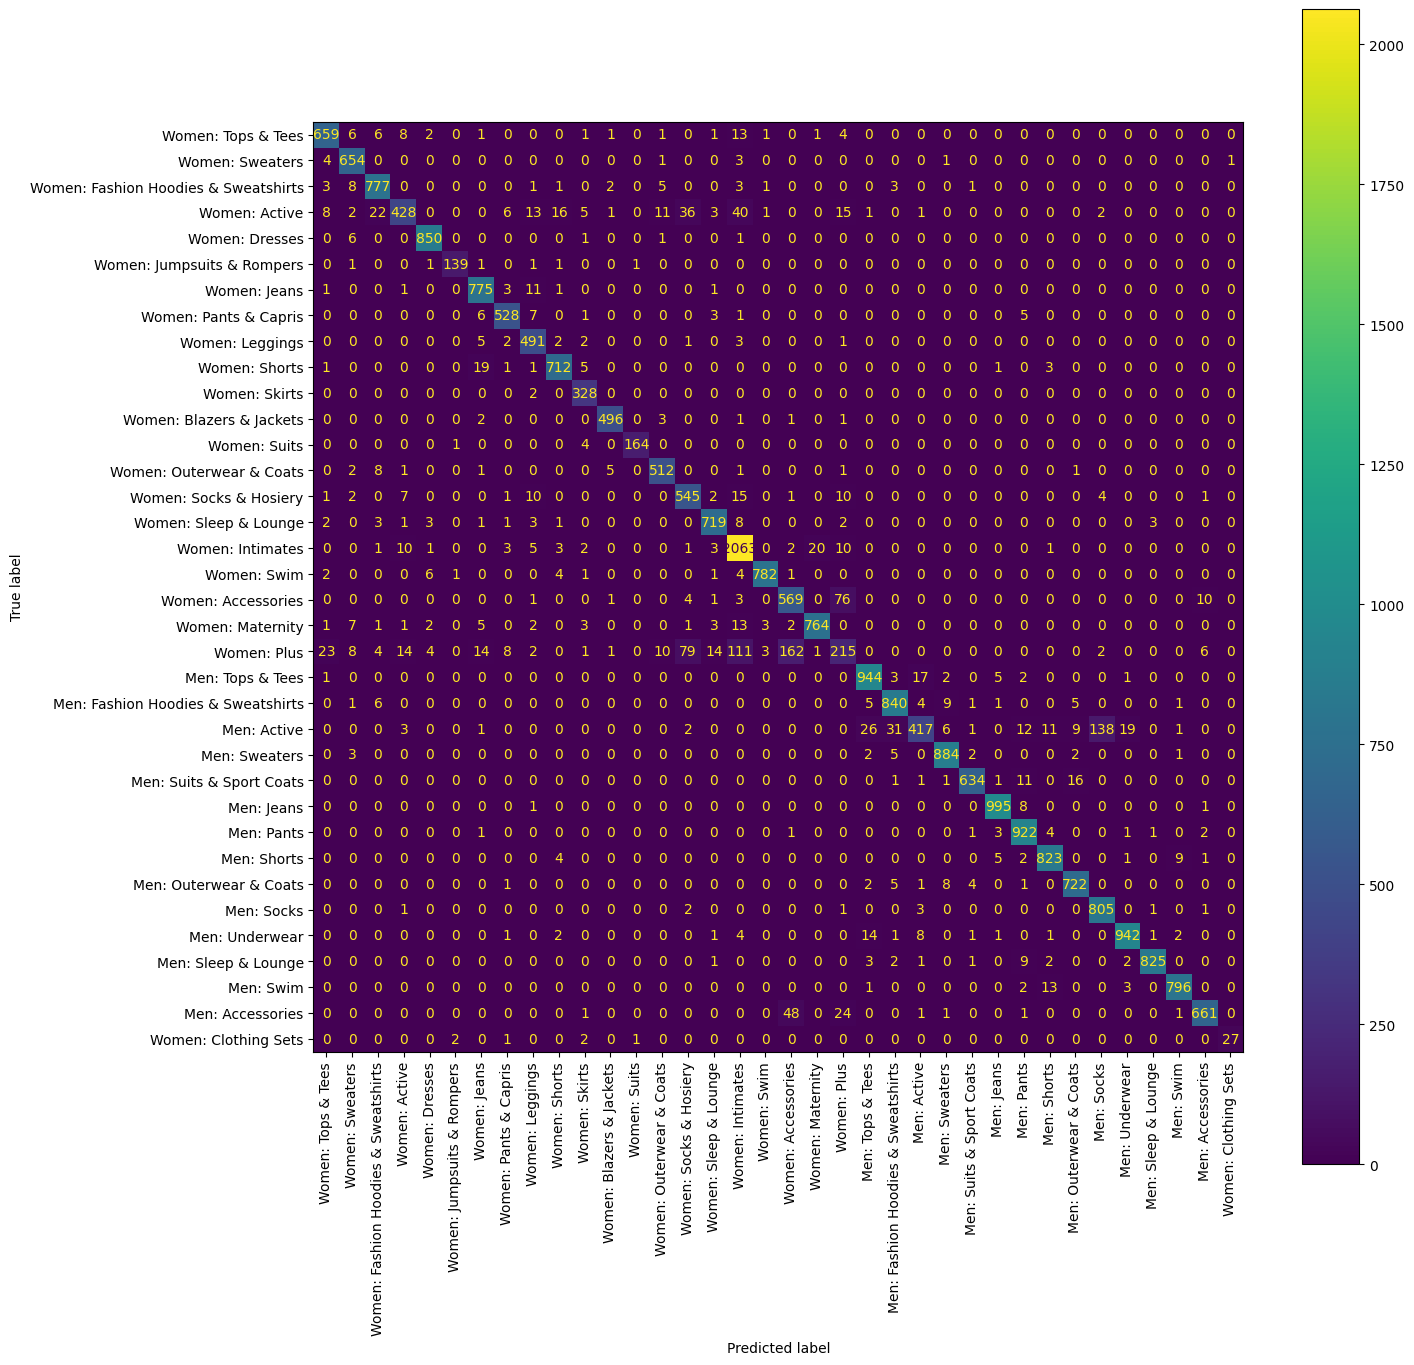

In [498]:
labels = list(train_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(train_pred['category']),
        list(train_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [499]:
print(
    metrics.classification_report(
        list(train_pred['category']),
        list(train_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.97      0.90      0.93       738
                         Men: Active       0.92      0.62      0.74       677
  Men: Fashion Hoodies & Sweatshirts       0.94      0.96      0.95       873
                          Men: Jeans       0.98      0.99      0.99      1005
              Men: Outerwear & Coats       0.96      0.97      0.96       744
                          Men: Pants       0.95      0.99      0.96       936
                         Men: Shorts       0.96      0.97      0.97       845
                 Men: Sleep & Lounge       0.99      0.98      0.98       846
                          Men: Socks       0.85      0.99      0.91       814
            Men: Suits & Sport Coats       0.98      0.95      0.97       665
                       Men: Sweaters       0.97      0.98      0.98       899
                           Men: Swim       0.98      0.98      

### Notes

This approach is even weaker than the concatenated embedding model (1). It does look like extending the training to additional iterations (stopped at default 20) and making deeper trees (defaulted to 6 here) would be beneficial. 

## (3) Model Serving: Classifier For Concatenated Embeddings AND Absolute Difference Between Embeddings

### Test Split

In [500]:
test_pred = predictor('classifier_conadiff', 'test')

In [501]:
test_pred.head()

,id,name,category,department,pred_department,pred_department_prob,pred_category,pred_category_prob
0,275,Bella Ladies raglan sleeves Flowy T-Shirt B8801,Women: Tops & Tees,Women,Women,0.999370,Women: Tops & Tees,0.303724
1,4751,Joe's Jeans Women's Colored Chelsea Jean,Women: Jeans,Women,Women,0.994625,Women: Jeans,0.611642
2,5392,Dockers Women's Plus-Size Trouser,Women: Pants & Capris,Women,Women,0.996152,Women: Pants & Capris,0.733982
3,5574,Tru-Spec Women's 100% Cotton 24-7 Series Pants,Women: Pants & Capris,Women,Women,0.999091,Women: Pants & Capris,0.335456
4,7763,Ulla Popken Plus Size Burnout Velvet Kimono Set,Women: Blazers & Jackets,Women,Women,0.999697,Women: Suits,0.013112


In [502]:
test_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,1242,77
Women,64,1545


In [503]:
print(
    metrics.classification_report(
        list(test_pred['department']),
        list(test_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       0.95      0.94      0.95      1319
       Women       0.95      0.96      0.96      1609

    accuracy                           0.95      2928
   macro avg       0.95      0.95      0.95      2928
weighted avg       0.95      0.95      0.95      2928



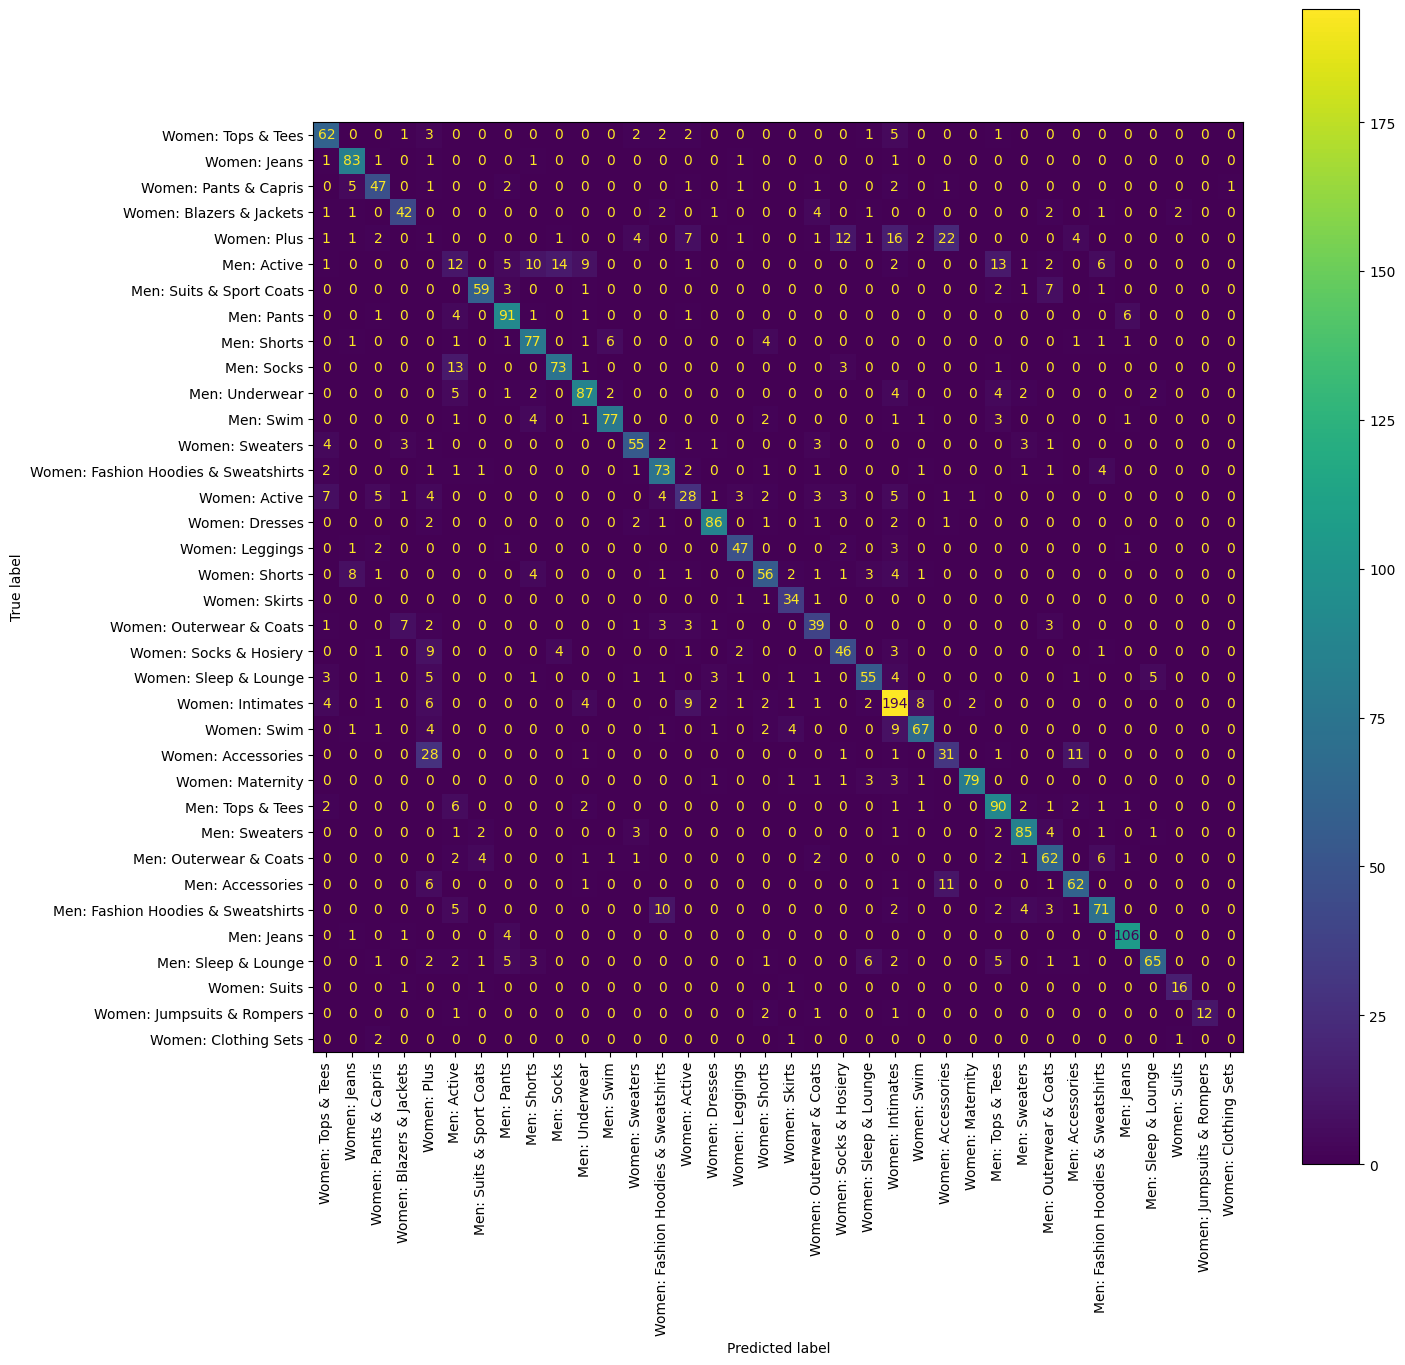

In [504]:
labels = list(test_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(test_pred['category']),
        list(test_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [505]:
print(
    metrics.classification_report(
        list(test_pred['category']),
        list(test_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.75      0.76      0.75        82
                         Men: Active       0.22      0.16      0.18        76
  Men: Fashion Hoodies & Sweatshirts       0.76      0.72      0.74        98
                          Men: Jeans       0.91      0.95      0.93       112
              Men: Outerwear & Coats       0.70      0.75      0.73        83
                          Men: Pants       0.81      0.87      0.83       105
                         Men: Shorts       0.75      0.82      0.78        94
                 Men: Sleep & Lounge       0.89      0.68      0.77        95
                          Men: Socks       0.79      0.80      0.80        91
            Men: Suits & Sport Coats       0.87      0.80      0.83        74
                       Men: Sweaters       0.85      0.85      0.85       100
                           Men: Swim       0.90      0.85      

### Train Split

In [506]:
train_pred = predictor('classifier_conadiff', 'train')

In [507]:
train_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,11726,85
Women,28,14351


In [508]:
print(
    metrics.classification_report(
        list(train_pred['department']),
        list(train_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       1.00      0.99      1.00     11811
       Women       0.99      1.00      1.00     14379

    accuracy                           1.00     26190
   macro avg       1.00      1.00      1.00     26190
weighted avg       1.00      1.00      1.00     26190



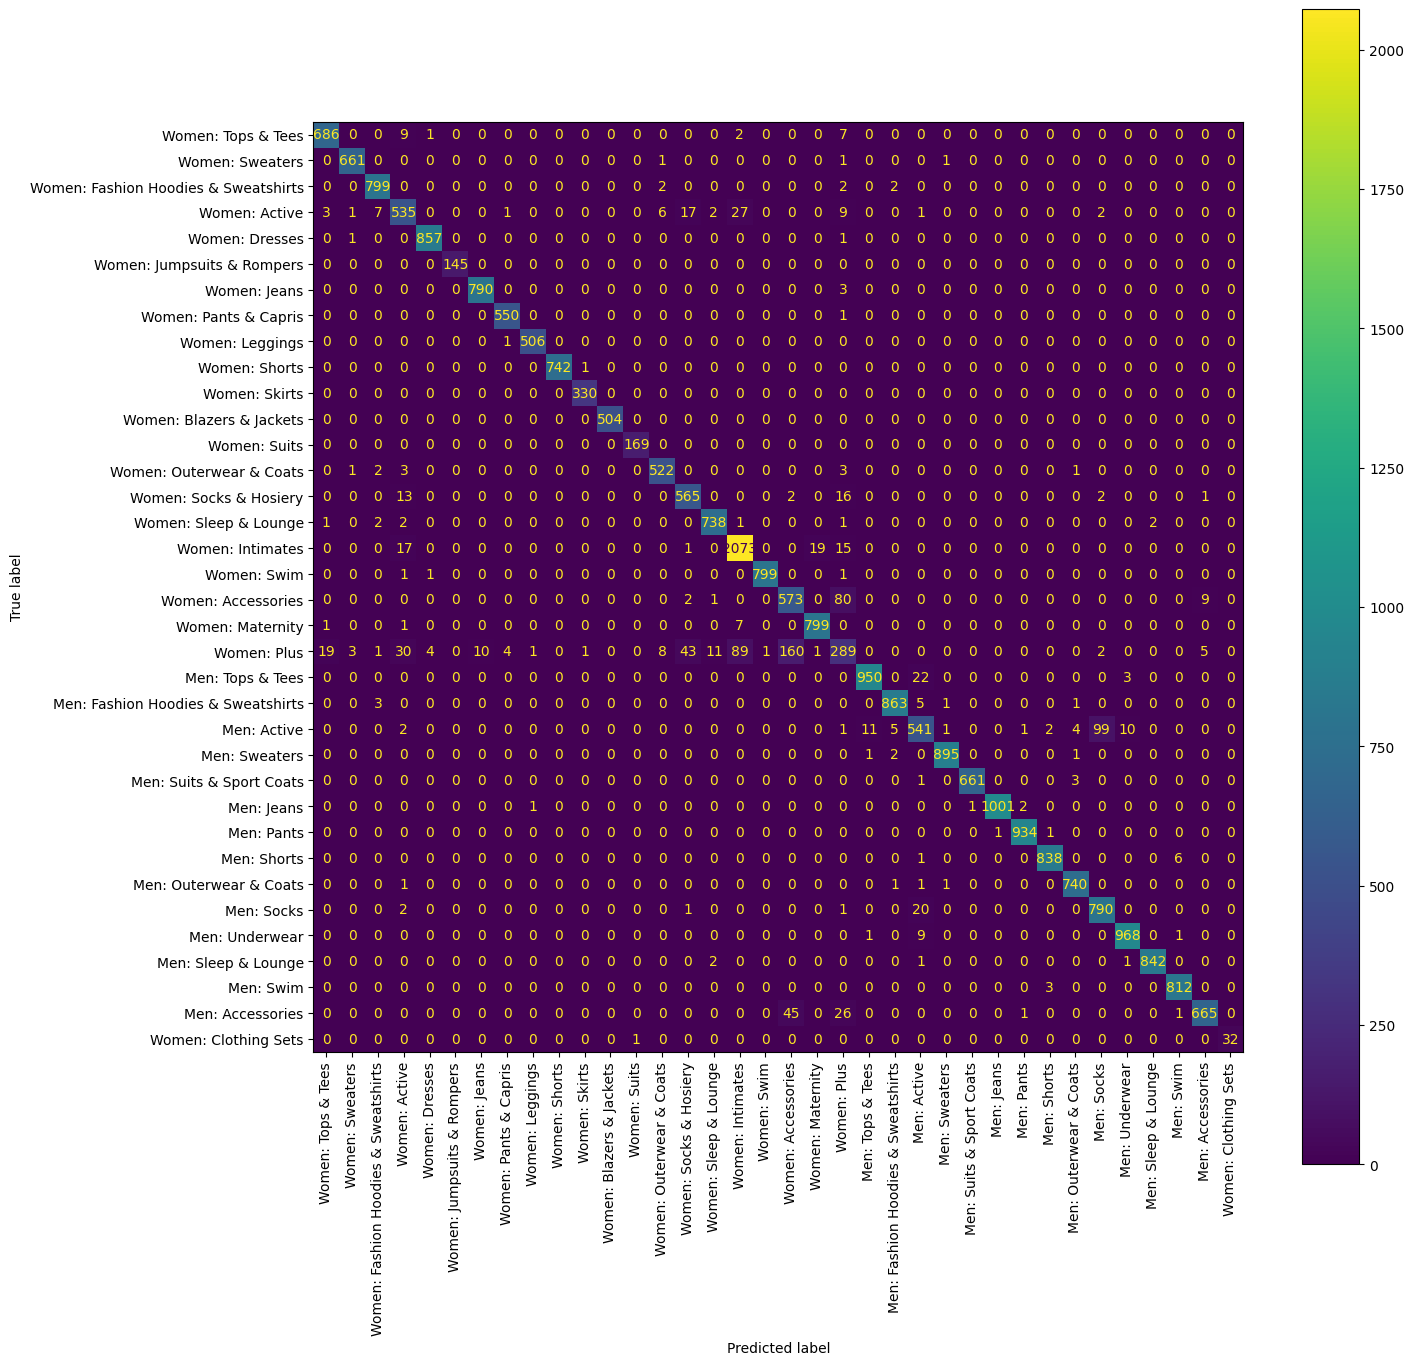

In [509]:
labels = list(train_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(train_pred['category']),
        list(train_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [510]:
print(
    metrics.classification_report(
        list(train_pred['category']),
        list(train_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.98      0.90      0.94       738
                         Men: Active       0.90      0.80      0.85       677
  Men: Fashion Hoodies & Sweatshirts       0.99      0.99      0.99       873
                          Men: Jeans       1.00      1.00      1.00      1005
              Men: Outerwear & Coats       0.99      0.99      0.99       744
                          Men: Pants       1.00      1.00      1.00       936
                         Men: Shorts       0.99      0.99      0.99       845
                 Men: Sleep & Lounge       1.00      1.00      1.00       846
                          Men: Socks       0.88      0.97      0.92       814
            Men: Suits & Sport Coats       1.00      0.99      1.00       665
                       Men: Sweaters       1.00      1.00      1.00       899
                           Men: Swim       0.99      1.00      

### Notes

This approach is is much more accurate due to the combined features sets as well as more iterations (20 increased to 50) and deeper trees (6 increased to 15).  This has led to overfitting for `category` as the training data accuracy is 0.96 while the test data is lower at 0.74.

## (4) Model Serving: Classifier For Concatenated Embeddings AND Absolute Difference Between Embeddings AND Product Metadata (price, cost, brand)

### Test Split

In [511]:
test_pred = predictor('classifier_metaconadiff', 'test')

In [512]:
test_pred.head()

,id,name,category,department,pred_department,pred_department_prob,pred_category,pred_category_prob
0,1593,Plus size Gray Deep cut v-neck Hoodie top,Women: Fashion Hoodies & Sweatshirts,Women,Women,0.970211,Women: Fashion Hoodies & Sweatshirts,0.047043
1,1703,Burton Women's Her Logo Zip Hoodie,Women: Fashion Hoodies & Sweatshirts,Women,Women,0.995288,Women: Fashion Hoodies & Sweatshirts,0.545598
2,2234,Escargot Sportswear - Crystal Cardinals Novelt...,Women: Fashion Hoodies & Sweatshirts,Women,Men,0.374595,Men: Sweaters,0.005937
3,2804,Mammut Women's Ultimate Hoody,Women: Active,Women,Women,0.996766,Women: Fashion Hoodies & Sweatshirts,0.836010
4,3130,Parker Women's Beaded Shift Dress,Women: Dresses,Women,Women,0.999247,Women: Dresses,0.982090


In [513]:
test_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,1251,68
Women,73,1536


In [514]:
print(
    metrics.classification_report(
        list(test_pred['department']),
        list(test_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       0.94      0.95      0.95      1319
       Women       0.96      0.95      0.96      1609

    accuracy                           0.95      2928
   macro avg       0.95      0.95      0.95      2928
weighted avg       0.95      0.95      0.95      2928



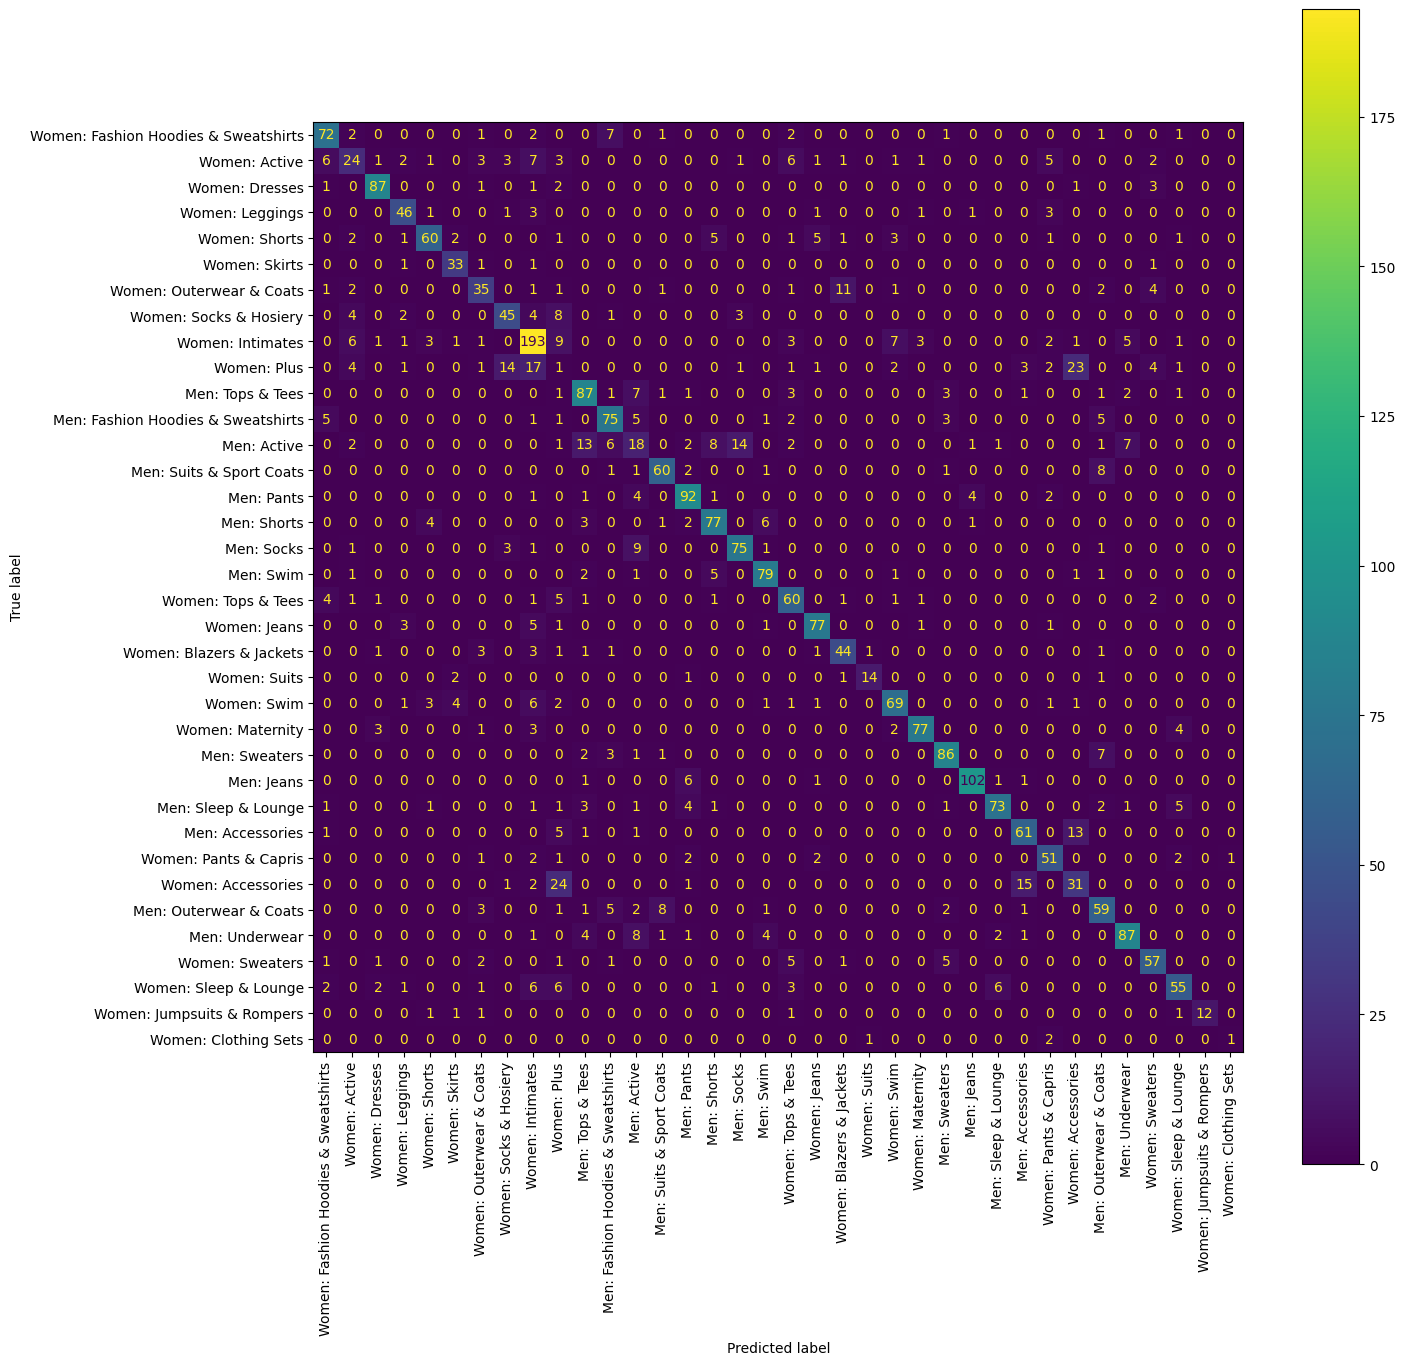

In [515]:
labels = list(test_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(test_pred['category']),
        list(test_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [516]:
print(
    metrics.classification_report(
        list(test_pred['category']),
        list(test_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.73      0.74      0.74        82
                         Men: Active       0.31      0.24      0.27        76
  Men: Fashion Hoodies & Sweatshirts       0.74      0.77      0.75        98
                          Men: Jeans       0.94      0.91      0.92       112
              Men: Outerwear & Coats       0.66      0.71      0.68        83
                          Men: Pants       0.81      0.88      0.84       105
                         Men: Shorts       0.78      0.82      0.80        94
                 Men: Sleep & Lounge       0.88      0.77      0.82        95
                          Men: Socks       0.80      0.82      0.81        91
            Men: Suits & Sport Coats       0.81      0.81      0.81        74
                       Men: Sweaters       0.84      0.86      0.85       100
                           Men: Swim       0.83      0.87      

### Train Split

In [517]:
train_pred = predictor('classifier_metaconadiff', 'train')

In [518]:
train_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,11774,37
Women,4,14375


In [519]:
print(
    metrics.classification_report(
        list(train_pred['department']),
        list(train_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       1.00      1.00      1.00     11811
       Women       1.00      1.00      1.00     14379

    accuracy                           1.00     26190
   macro avg       1.00      1.00      1.00     26190
weighted avg       1.00      1.00      1.00     26190



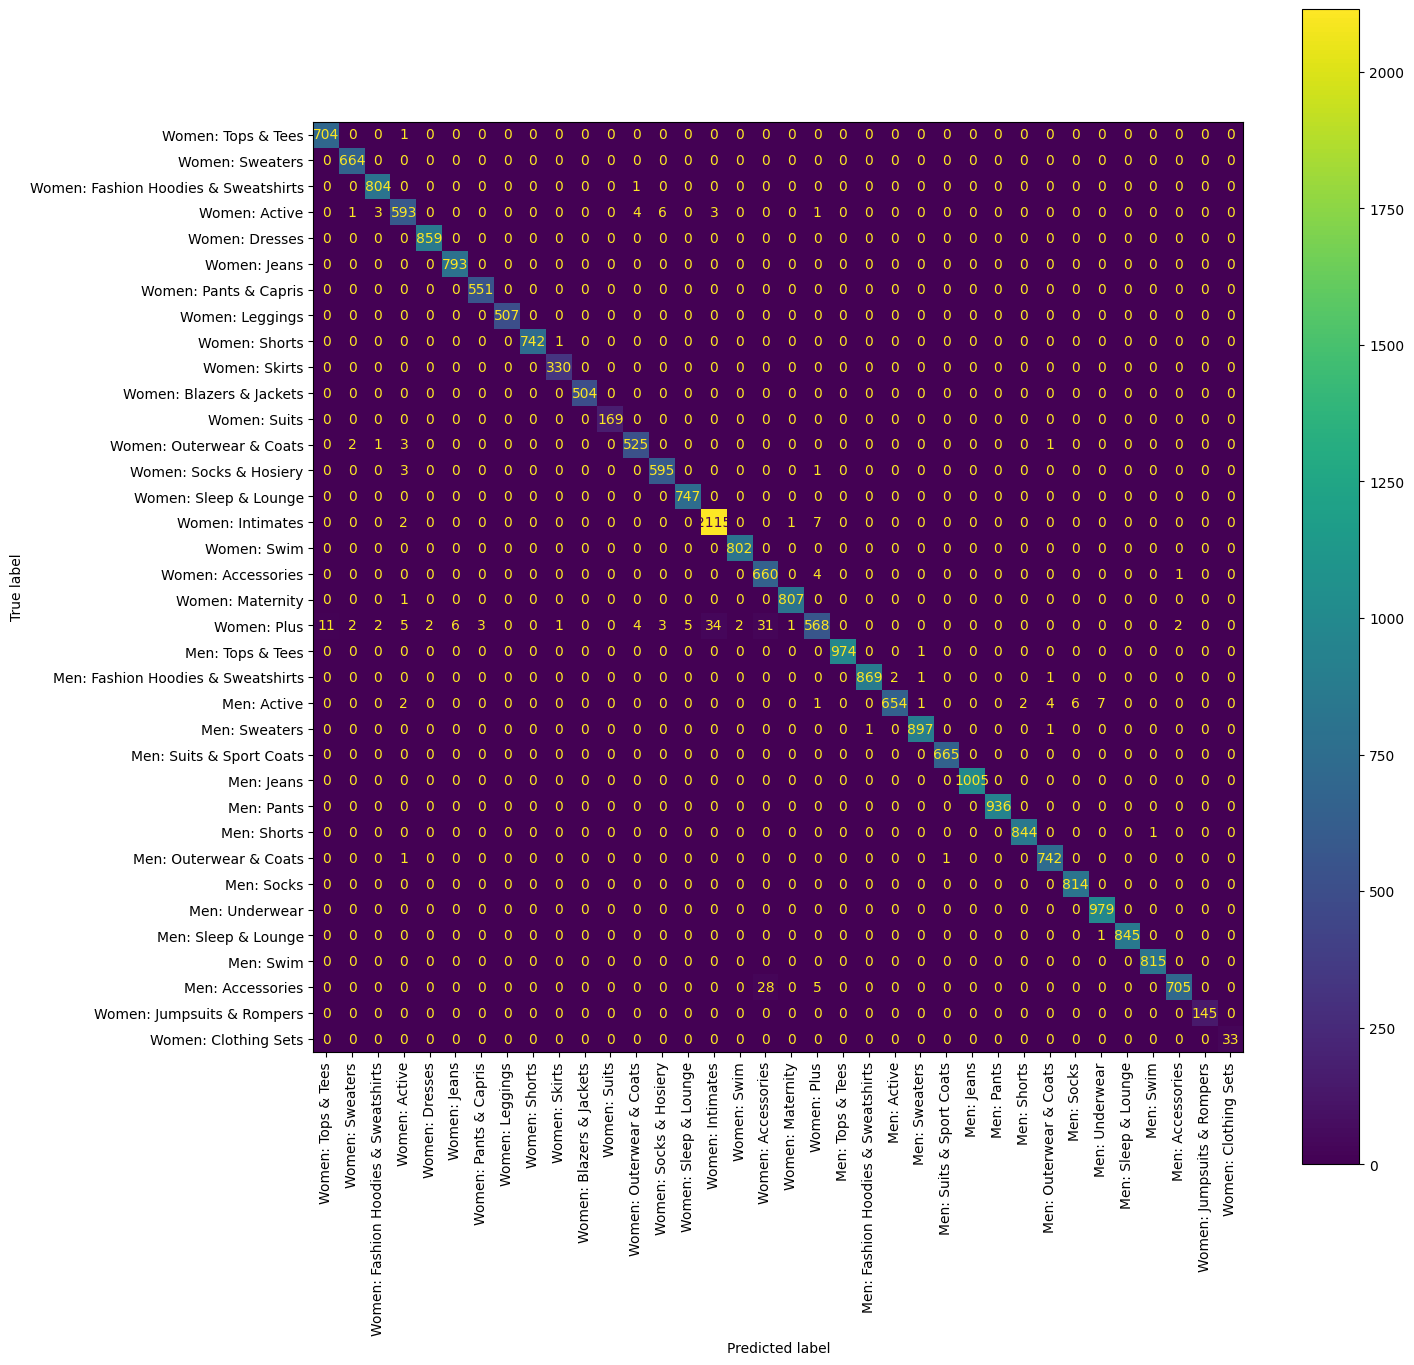

In [520]:
labels = list(train_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(train_pred['category']),
        list(train_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [521]:
print(
    metrics.classification_report(
        list(train_pred['category']),
        list(train_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       1.00      0.96      0.98       738
                         Men: Active       1.00      0.97      0.98       677
  Men: Fashion Hoodies & Sweatshirts       1.00      1.00      1.00       873
                          Men: Jeans       1.00      1.00      1.00      1005
              Men: Outerwear & Coats       0.99      1.00      0.99       744
                          Men: Pants       1.00      1.00      1.00       936
                         Men: Shorts       1.00      1.00      1.00       845
                 Men: Sleep & Lounge       1.00      1.00      1.00       846
                          Men: Socks       0.99      1.00      1.00       814
            Men: Suits & Sport Coats       1.00      1.00      1.00       665
                       Men: Sweaters       1.00      1.00      1.00       899
                           Men: Swim       1.00      1.00      

### Notes

This approach is is much more accurate due to adding product metadata to the combined features sets as well as more iterations (20 increased to 50) and deeper trees (6 increased to 12).  This has led to overfitting for `category` as the training data accuracy is 0.99 while the test data is lower at 0.74.

## (5) Model Serving: Metadata PLUS Absolute Difference Between Embeddings AND Product Metadata (price, cost, brand)

### Test Split

In [54]:
test_pred = predictor('classifier_forest_metaconadiff', 'test')

In [55]:
test_pred.head()

,id,name,category,department,pred_department,pred_department_prob,pred_category,pred_category_prob
0,1926,Champion Full Zip Hooded Sweatshirt,Women: Fashion Hoodies & Sweatshirts,Women,Women,0.819246,Women: Fashion Hoodies & Sweatshirts,0.732654
1,3984,Donna Morgan Women's Stitched Down Pleat Front...,Women: Dresses,Women,Women,0.959460,Women: Dresses,0.876419
2,5259,Woman Within Plus Size Leggings capri length i...,Women: Pants & Capris,Women,Women,0.997270,Women: Pants & Capris,0.768674
3,6474,Big Star Women's Remy Cuffed Short,Women: Shorts,Women,Women,0.992948,Women: Shorts,0.838701
4,6686,Womens BILLABONG OLD SCHOOL Casual Beach & Sur...,Women: Shorts,Women,Women,0.954541,Women: Shorts,0.884668


In [56]:
test_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,1304,15
Women,6,1603


In [57]:
print(
    metrics.classification_report(
        list(test_pred['department']),
        list(test_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       1.00      0.99      0.99      1319
       Women       0.99      1.00      0.99      1609

    accuracy                           0.99      2928
   macro avg       0.99      0.99      0.99      2928
weighted avg       0.99      0.99      0.99      2928



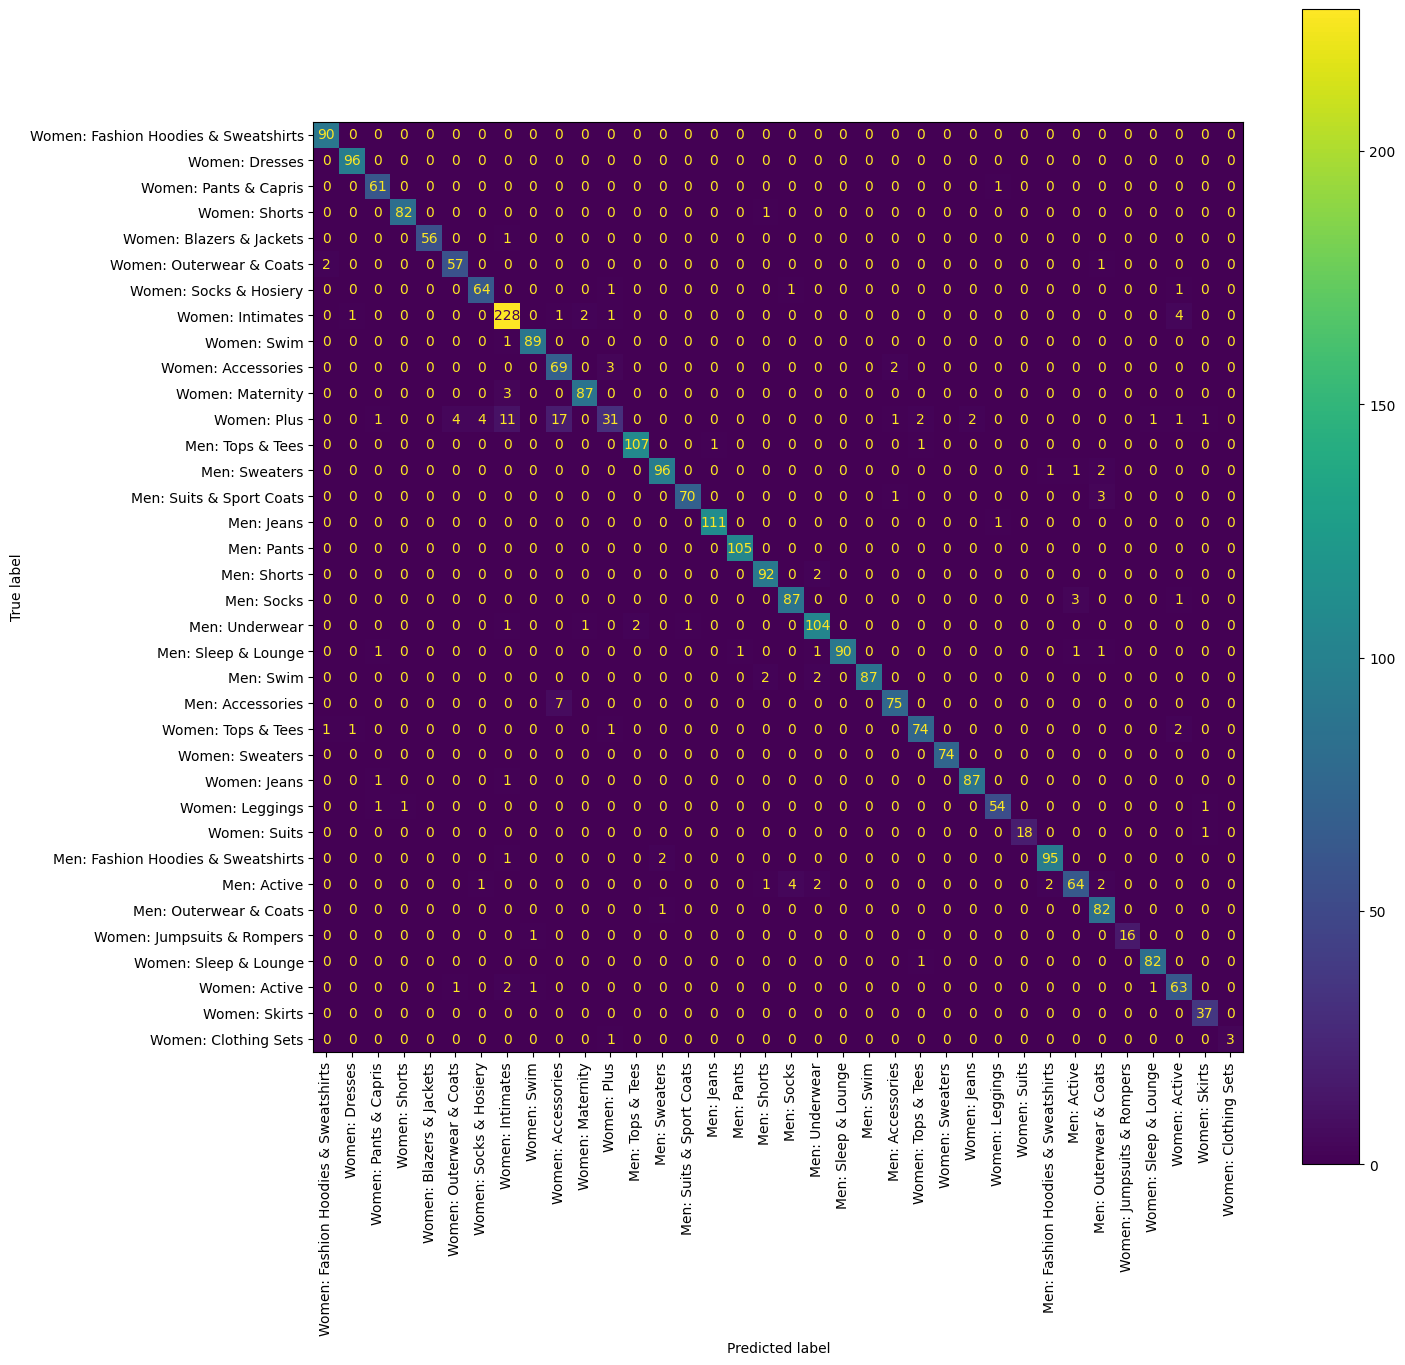

In [58]:
labels = list(test_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(test_pred['category']),
        list(test_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [59]:
print(
    metrics.classification_report(
        list(test_pred['category']),
        list(test_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.95      0.91      0.93        82
                         Men: Active       0.93      0.84      0.88        76
  Men: Fashion Hoodies & Sweatshirts       0.97      0.97      0.97        98
                          Men: Jeans       0.99      0.99      0.99       112
              Men: Outerwear & Coats       0.90      0.99      0.94        83
                          Men: Pants       0.99      1.00      1.00       105
                         Men: Shorts       0.96      0.98      0.97        94
                 Men: Sleep & Lounge       1.00      0.95      0.97        95
                          Men: Socks       0.95      0.96      0.95        91
            Men: Suits & Sport Coats       0.99      0.95      0.97        74
                       Men: Sweaters       0.97      0.96      0.96       100
                           Men: Swim       1.00      0.96      

### Train Split

In [60]:
train_pred = predictor('classifier_forest_metaconadiff', 'train')

In [61]:
train_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,11678,133
Women,72,14307


In [62]:
print(
    metrics.classification_report(
        list(train_pred['department']),
        list(train_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       0.99      0.99      0.99     11811
       Women       0.99      0.99      0.99     14379

    accuracy                           0.99     26190
   macro avg       0.99      0.99      0.99     26190
weighted avg       0.99      0.99      0.99     26190



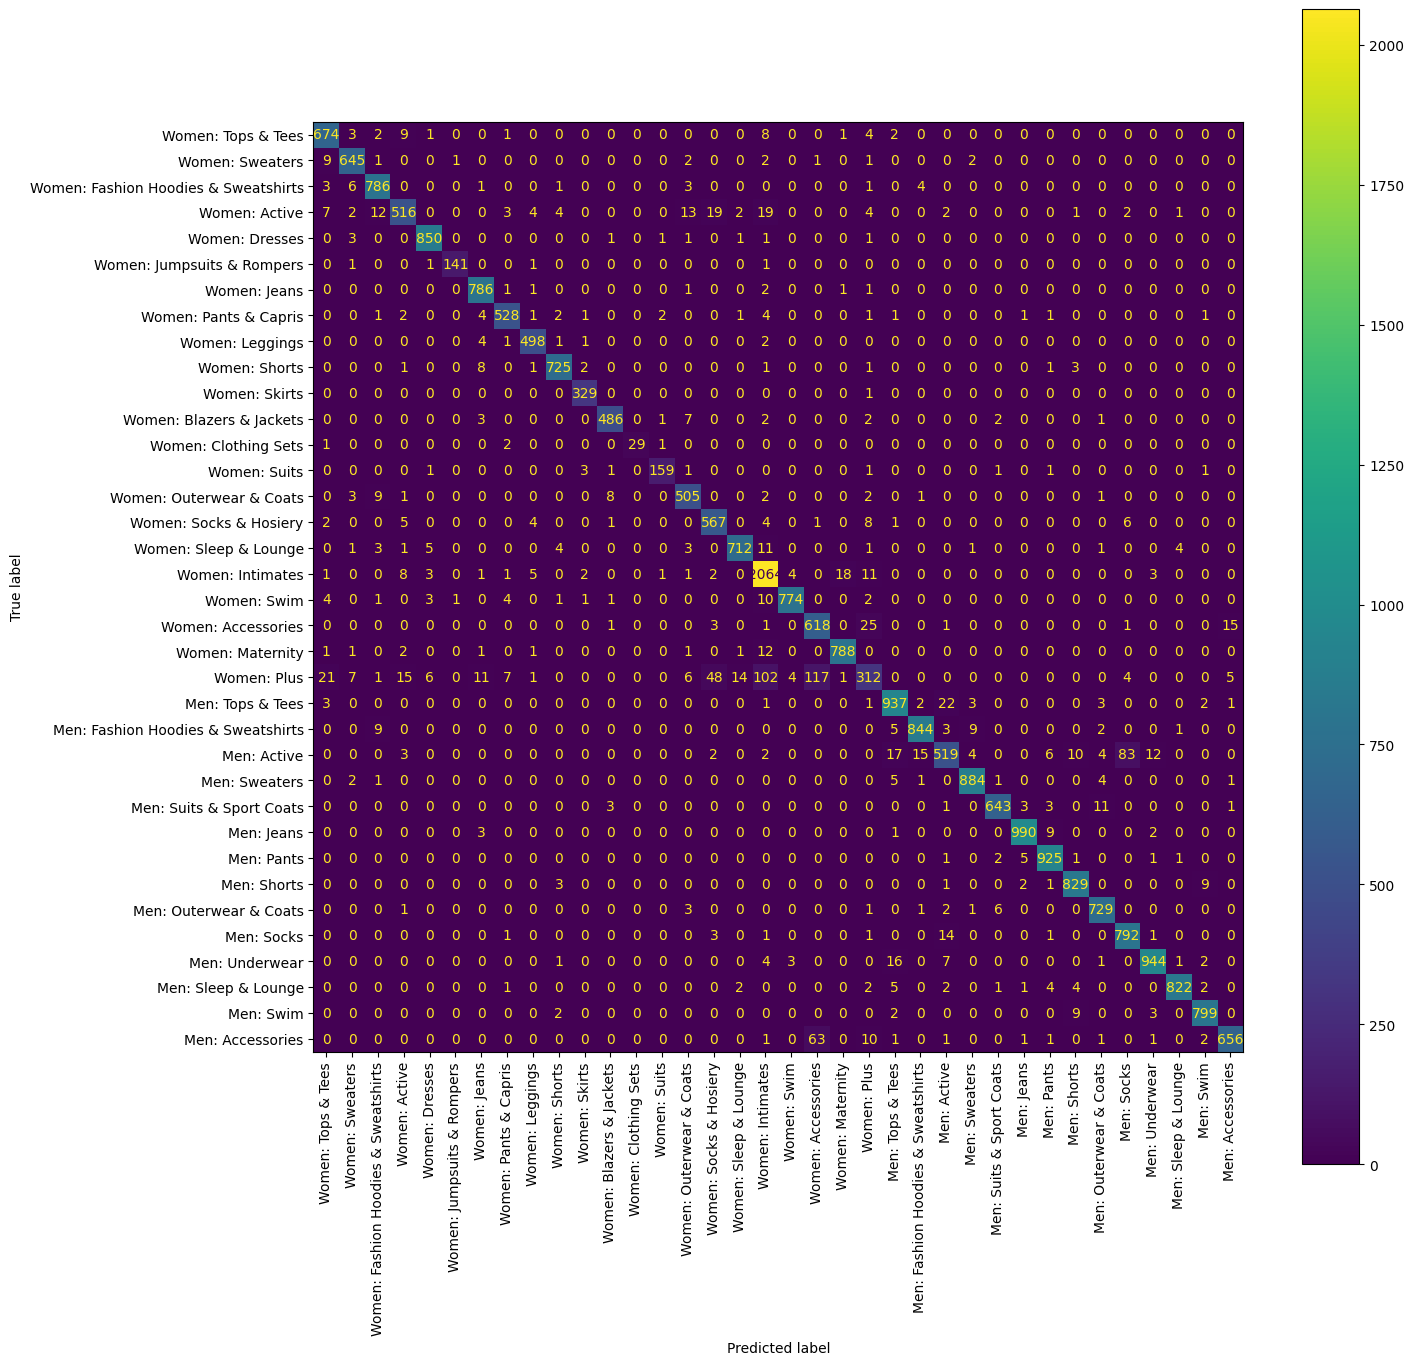

In [63]:
labels = list(train_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(train_pred['category']),
        list(train_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [64]:
print(
    metrics.classification_report(
        list(train_pred['category']),
        list(train_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.97      0.89      0.93       738
                         Men: Active       0.90      0.77      0.83       677
  Men: Fashion Hoodies & Sweatshirts       0.97      0.97      0.97       873
                          Men: Jeans       0.99      0.99      0.99      1005
              Men: Outerwear & Coats       0.96      0.98      0.97       744
                          Men: Pants       0.97      0.99      0.98       936
                         Men: Shorts       0.97      0.98      0.97       845
                 Men: Sleep & Lounge       0.99      0.97      0.98       846
                          Men: Socks       0.89      0.97      0.93       814
            Men: Suits & Sport Coats       0.98      0.97      0.97       665
                       Men: Sweaters       0.98      0.98      0.98       899
                           Men: Swim       0.98      0.98      

### Notes

The issues over overfitting observed in approaches 1-4 has been overcome while preserving accuracy!  The Train accuracy for categories is 0.95 while also 0.95 for test data.

## Deeper Investigation Of Inference

Now that there is a good candidate model, number 5, it is time to understand where it is mis-classifying products.  This insight will help with understanding how to make the model better, or it might even uncover issues with the data be labeled incorrectly.

---
## Thoughts On Next Steps

The workflow shows that building a product placement preditor is feasible.  The next step would be iterating on model development to increase accuracy and generalizability.  If product images were available then using multi-modal embeddings would likely be a big boost in accuracy here.

When examining the errors it also appears that some mis-classified items could actually belong to more than one category.  This means that either a muli-label approach or first prioritizing categorization and correcting the catalog could be helpful.  As an example, a common mis-classification is assessories between Mens and Womens when it might be that these are actually the same item possible within both = multi label.

---
## Remove Resources

In [151]:
#bq_connection.ConnectionServiceClient().delete_connection(name = f"projects/{BQ_PROJECT}/locations/{BQ_REGION}/connections/{SERIES}_{EXPERIMENT}")